# **Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.isotonic import spearmanr
import tensorflow as tf
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# **Preprocessing**

# **Basic Cleaning**

In [3]:
df = pd.read_csv("GuestSatisfactionPrediction.csv")
df.head()

<ipython-input-3-f41ae7a1ecf1>:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("GuestSatisfactionPrediction.csv")


,id,listing_url,name,summary,space,description,neighborhood_overview,notes,transit,access,...,number_of_stays,first_review,last_review,review_scores_rating,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,21514496,https://www.airbnb.com/rooms/21514496,PRIVATE BEDROOM DOWNTOWN 2 BED/ 2 BATH #5,Beautiful 2 bedroom 2 bathroom furnished apart...,Each apartment is fully furnished and consists...,Beautiful 2 bedroom 2 bathroom furnished apart...,NaN,***Note that the pictures on the website may o...,NaN,NaN,...,2,11/17/2017,11/17/2017,80.0,f,f,f,strict_14_with_grace_period,f,f
1,990185,https://www.airbnb.com/rooms/990185,4 bed/2 ba Family Retreat in SD,We feel our house is a great place for a famil...,Our house is ideal for large families or group...,We feel our house is a great place for a famil...,Neighborhood Mira Mesa is a culturally diverse...,NaN,NaN,Our guests may use the BBQ grill.,...,26,8/2/2013,7/31/2019,97.0,f,f,f,moderate,f,f
2,19878244,https://www.airbnb.com/rooms/19878244,San Diego Dream Villa,"Zen, Luxury and the Best Location in Americas ...","San Diego Dream Villa, this unique and luxurio...","Zen, Luxury and the Best Location in Americas ...",This amazing house is located within a few min...,Im always available to make your trip experien...,"If you are bringing your car, remember that SD...",A couple of days before your arrival you will ...,...,170,7/23/2017,7/16/2019,98.0,f,f,f,strict_14_with_grace_period,f,f
3,24561458,https://www.airbnb.com/rooms/24561458,Studio with Piazza View in Downtown Little Italy,Start the day with breakfast on the sunny pati...,"Newly built, this beautiful studio is located ...",Start the day with breakfast on the sunny pati...,"Spend the day at the zoo in Balboa Park, or ex...",The apartment is located on the Piazza Della F...,"MTS, Train, and Trolly are close by. The airpo...",You will not be sharing the apartment with any...,...,212,5/1/2018,8/3/2019,98.0,f,t,f,moderate,f,f
4,32269829,https://www.airbnb.com/rooms/32269829,Beachside Retreat w/ Private Rooftop Deck w/ V...,This is a 2 bedroom/1 bathroom beachside unit...,Beach living at its finest! The highlight of ...,This is a 2 bedroom/1 bathroom beachside unit...,Mission Beach is an amazing coastal community ...,NaN,The Boardwalk and Bayside Walk are wonderful w...,This is a private home that is part of a typic...,...,2,6/30/2019,6/30/2019,100.0,f,t,f,strict_14_with_grace_period,f,f


**INITAL** **DROPS**

In [4]:
drop_columns = ['thumbnail_url', 'host_acceptance_rate','square_feet','is_business_travel_ready','requires_license','id','country_code','summary',
                'host_url','listing_url','name','neighbourhood','street','host_has_profile_pic','country','smart_location','market','state','city',
                'bed_type','require_guest_phone_verification','require_guest_profile_picture', 'host_name', 'space','host_total_listings_count',
                'latitude', 'longitude']
df.drop(columns=drop_columns, inplace=True)

Y = df['review_scores_rating']


**Neseccsary Convergances**

In [5]:
df['extra_people'] = df['extra_people'].replace(r'[\$,]', '', regex=True).astype(float)
df['nightly_price'] = df['nightly_price'].replace(r'[\$,]', '', regex=True).astype(float)
df['price_per_stay'] = df['price_per_stay'].replace(r'[\$,]', '', regex=True).astype(float)
df['security_deposit'] = df['security_deposit'].replace(r'[\$,]', '', regex=True).astype(float)
df['cleaning_fee'] = df['cleaning_fee'].replace(r'[\$,]', '', regex=True).astype(float)
df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce')
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')


# **Feature Engineering**

In [6]:

df['review_duration_days'] = (df['last_review'] - df['first_review']).dt.days
df['review_duration_months'] = df['review_duration_days'] / 30
zero_month_count = (df['review_duration_months'] == 0).sum()
total_rows = len(df)
percentage_zero_months = (zero_month_count / total_rows) * 100

print(f"Percentage of zero-month durations: {percentage_zero_months:.2f}%") #hnemla al 8% dool b eh??
print(df[['first_review', 'last_review', 'review_duration_months', 'review_duration_days']].head())
print(df['review_duration_months'].max())
print(df['review_duration_days'].max())
#7asa nsta5dem aly b al mounths 3shan ranges mn 0 : 96 f al model msh hyjudge al bigger value 3la enha aham
#kalam gbt
# Use review_duration_months if you're doing general modeling, classification, or exploratory analysis — it's easier to interpret, and still captures duration meaningfully.

#Use review_duration_days if you're doing fine-grained, time-sensitive predictions (like daily pricing models, or user behavior based on exact durations).



Percentage of zero-month durations: 7.77%
  first_review last_review  review_duration_months  review_duration_days
0   2017-11-17  2017-11-17                0.000000                     0
1   2013-08-02  2019-07-31               72.966667                  2189
2   2017-07-23  2019-07-16               24.100000                   723
3   2018-05-01  2019-08-03               15.300000                   459
4   2019-06-30  2019-06-30                0.000000                     0
129.53333333333333
3886


In [7]:
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
df['host_duration_days'] = (pd.to_datetime("today") - df['host_since']).dt.days
df['host_duration_months'] = df['host_duration_days'] / 30
df['host_duration_years'] = df['host_duration_days'] / 365.25
print(df[['host_since', 'host_duration_days', 'host_duration_months', 'host_duration_years']].head())
print(df['host_duration_days'].max())
print(df['host_duration_months'].max())
print(df['host_duration_years'].max())
#7asa al years ansab 7aga

  host_since  host_duration_days  host_duration_months  host_duration_years
0 2012-10-15              4576.0            152.533333            12.528405
1 2013-01-29              4470.0            149.000000            12.238193
2 2013-11-05              4190.0            139.666667            11.471595
3 2018-04-11              2572.0             85.733333             7.041752
4 2013-08-23              4264.0            142.133333            11.674196
6263.0
208.76666666666668
17.14715947980835


In [8]:
oldest_host_date = df['host_since'].min()
df['host_relative_age_days'] = (df['host_since'] - oldest_host_date).dt.days
df['host_relative_age_months'] = df['host_relative_age_days'] / 30
df['host_relative_age_years'] = df['host_relative_age_days'] / 365.25
print(df[['host_since', 'host_relative_age_days', 'host_relative_age_months', 'host_relative_age_years']].head())
zero_month_count = (df['host_relative_age_days'] == 0).sum()
total_rows = len(df)
percentage_zero_months = (zero_month_count / total_rows) * 100
print(df['host_relative_age_days'].max())
print(df['host_relative_age_months'].max())
print(df['host_relative_age_years'].max())
print(f"Percentage of zero-month durations relative host: {percentage_zero_months:.2f}%")#percentage msh kbeera f eshta
#years ansab 7aga bardoo

  host_since  host_relative_age_days  host_relative_age_months  \
0 2012-10-15                  1687.0                 56.233333   
1 2013-01-29                  1793.0                 59.766667   
2 2013-11-05                  2073.0                 69.100000   
3 2018-04-11                  3691.0                123.033333   
4 2013-08-23                  1999.0                 66.633333   

   host_relative_age_years  
0                 4.618754  
1                 4.908966  
2                 5.675565  
3                10.105407  
4                 5.472964  
4176.0
139.2
11.433264887063656
Percentage of zero-month durations relative host: 0.01%


In [9]:
drop_columns = ['first_review',
                'last_review','host_since']
df.drop(columns=drop_columns, inplace=True)

# **Filling Missing Values**

In [10]:
# Fill text fields with empty string
columns = [ 'description','transit', 'access', 'interaction', 'house_rules']
df[columns] = df[columns].fillna('No information provided')

In [11]:
# Fill categorical with mode
categorical_cols = [ 'host_location','host_is_superhost',
                     'host_identity_verified',]
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [12]:
### --- Fill 'host_neighbourhood' using 'neighbourhood_cleansed' ---
df['host_neighbourhood'] = df.groupby('neighbourhood_cleansed')['host_neighbourhood'] \
    .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['host_neighbourhood'].mode()[0]))

# If still missing, fill with overall mode
df['host_neighbourhood'] = df['host_neighbourhood'].fillna(df['host_neighbourhood'].mode()[0])

### --- Fill 'host_response_time' using 'host_is_superhost' and 'host_response_rate' ---
df['host_response_time'] = df.groupby(['host_is_superhost', 'host_response_rate'])['host_response_time'] \
    .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['host_response_time'].mode()[0]))

# If still missing, fill with overall mode
df['host_response_time'] = df['host_response_time'].fillna(df['host_response_time'].mode()[0])

df['neighborhood_overview'] = df.groupby('neighbourhood_cleansed')['neighborhood_overview'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "No overview available")
)

# If still missing, fill with overall mode
df['neighborhood_overview'] = df['neighborhood_overview'].fillna(df['neighborhood_overview'].mode()[0])

In [13]:
# Fill 'host_about' if missing
df['host_about'] = df.apply(
    lambda row: (
        "is a host offering a {row['room_type']} in {row['neighbourhood_cleansed']}. "
        f"Guests usually enjoy a {row['property_type']} with great hospitality."
        if pd.isnull(row['host_about']) else row['host_about']
    ), axis=1
)

# Fill 'notes' if missing
df['notes'] = df.apply(
    lambda row: (
        f"This {row['room_type']} in {row['neighbourhood_cleansed']} offers a comfortable stay. "
        f"Arrival instructions and local tips will be shared after booking."
        if pd.isnull(row['notes']) else row['notes']
    ), axis=1
)

In [14]:
# Safely strip '%' and convert to float
df['host_response_rate'] = df['host_response_rate'].astype(str).str.rstrip('%')
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce')
df['host_response_rate'] = df['host_response_rate'].fillna(df['host_response_rate'].median())

In [15]:
# Clean 'zipcode': keep only the first 5 digits
df['zipcode'] = df['zipcode'].astype(str).str.extract(r'(\d{5})')
df['zipcode'] = pd.to_numeric(df['zipcode'], errors='coerce')

# Fill all numeric columns with median
numeric_cols_median = ['zipcode', 'bathrooms', 'bedrooms', 'beds', 'host_listings_count']

for col in numeric_cols_median:
    df[col] = df[col].fillna(df[col].median())

In [16]:
# Optional numeric financials
df['security_deposit'] = df['security_deposit'].fillna(0)
df['cleaning_fee'] = df['cleaning_fee'].fillna(0)

In [17]:
# Columns with only 1 missing value
single_missing = df.columns[df.isnull().sum() == 1]
for col in single_missing:
    df[col] = df[col].fillna(df[col].mode()[0] if df[col].dtype == 'O' else df[col].median())

In [18]:
if 'neighbourhood' in df.columns:
    df.drop('neighbourhood', axis=1, inplace=True)


# Build the summary table
summary = pd.DataFrame({
    'Feature': df.columns,
    'Data Type': df.dtypes.values,
    'Missing Values': df.isnull().sum().values
})

# Sort by number of missing values (descending)
summary = summary.sort_values(by='Missing Values', ascending=False).reset_index(drop=True)

# Display all 69 rows
pd.set_option('display.max_rows', None)
print(summary)

                     Feature Data Type  Missing Values
0                description    object               0
1      neighborhood_overview    object               0
2                      notes    object               0
3                    transit    object               0
4                     access    object               0
5                interaction    object               0
6                house_rules    object               0
7                    host_id     int64               0
8              host_location    object               0
9                 host_about    object               0
10        host_response_time    object               0
11        host_response_rate   float64               0
12         host_is_superhost    object               0
13        host_neighbourhood    object               0
14       host_listings_count   float64               0
15    host_identity_verified    object               0
16    neighbourhood_cleansed    object               0
17        

# **Some Visualizations**

In [19]:
#make a function that gets numerical / categorical values automatically

#Numerical_cols = [ 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds','nightly_price', 'price_per_stay', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_stays', 'review_scores_rating','review_duration_days', 'review_duration_months', 'host_duration_days', 'host_duration_months', 'host_duration_years', 'host_relative_age_days', 'host_relative_age_months', 'host_relative_age_years']

def get_numeric_columns(df, sample_ratio=0.3):
    numeric_columns = []

    for col in df.columns:
        sample = df[col].dropna().sample(frac=min(sample_ratio, 1.0), random_state=42)

        is_numeric = sample.apply(lambda x: isinstance(x, (int, float))).mean() > 0.8

        if is_numeric:
            numeric_columns.append(col)

    return numeric_columns
def get_categorical_columns(df, sample_ratio=0.3, max_unique=2):
    categorical_columns = []

    for col in df.columns:
        sample = df[col].dropna().sample(frac=min(sample_ratio, 1.0), random_state=42)

        if sample.nunique() <= max_unique:
            categorical_columns.append(col)

    return categorical_columns
Numerical_cols = get_numeric_columns(df)
Categorical_cols = get_categorical_columns(df)
print("Numerical columns:", Numerical_cols)
print('///////////////////////////////////////////////////////////////////')
#Categorical_cols = [ 'is_location_exact', 'host_identity_verified','host_is_superhost','host_response_rate','instant_bookable' ]
print("categorical columns:", Categorical_cols)


Numerical columns: ['host_id', 'host_response_rate', 'host_listings_count', 'zipcode', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'nightly_price', 'price_per_stay', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_stays', 'review_scores_rating', 'review_duration_days', 'review_duration_months', 'host_duration_days', 'host_duration_months', 'host_duration_years', 'host_relative_age_days', 'host_relative_age_months', 'host_relative_age_years']
///////////////////////////////////////////////////////////////////
categorical columns: ['host_is_superhost', 'host_identity_verified', 'is_location_exact', 'instant_bookable']


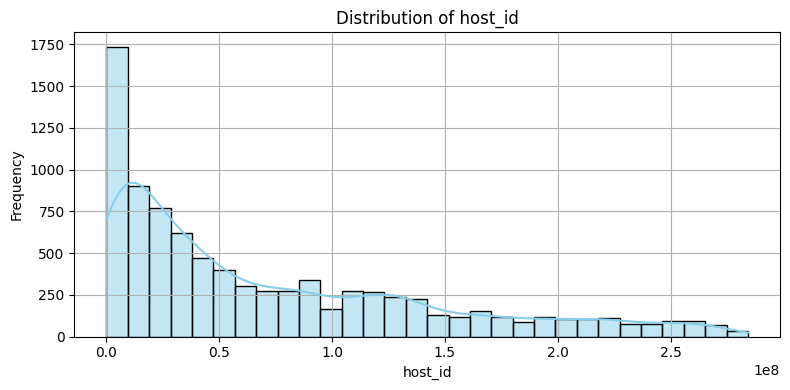

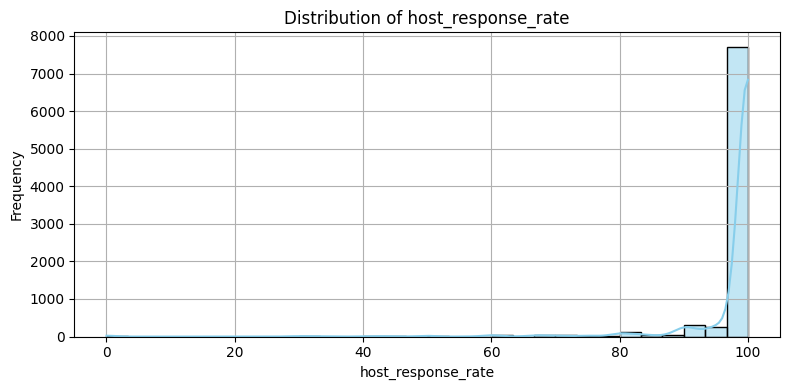

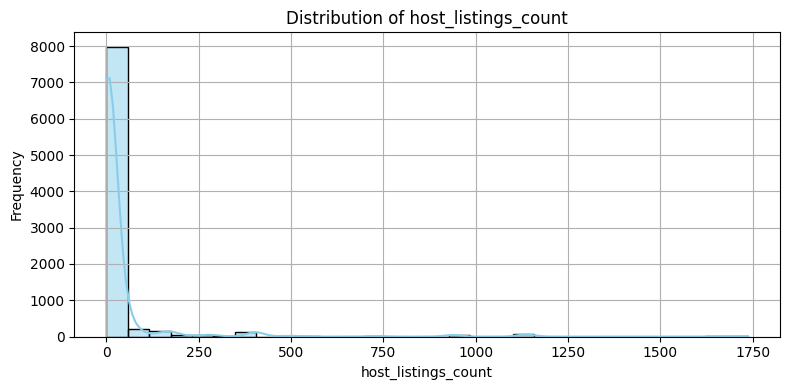

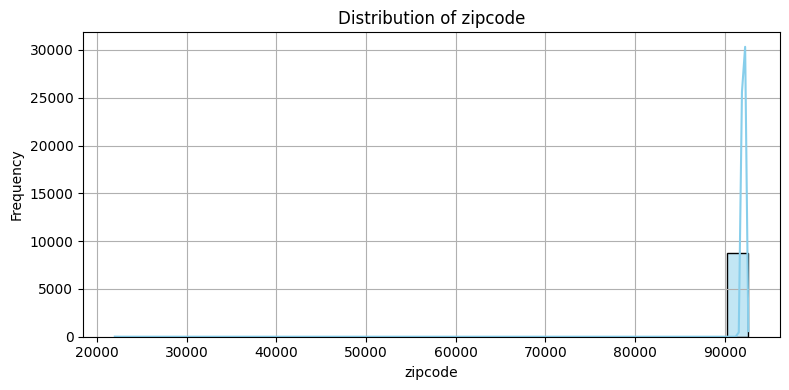

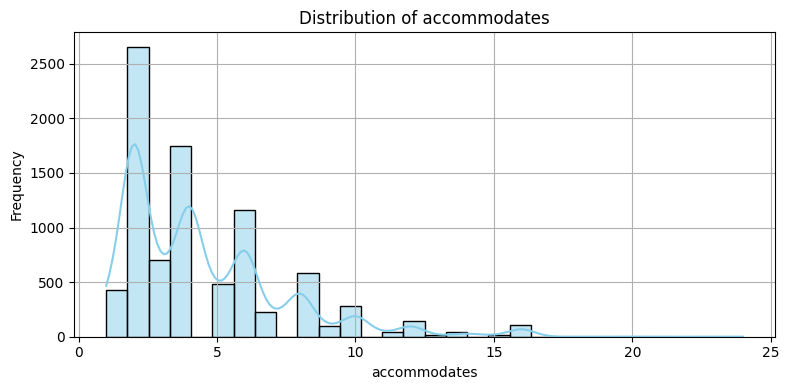

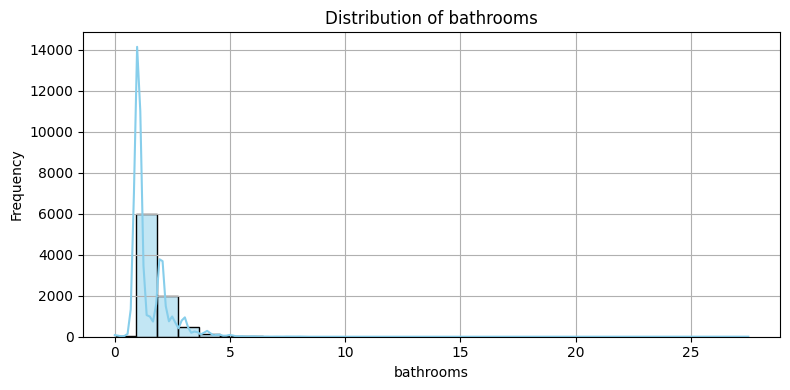

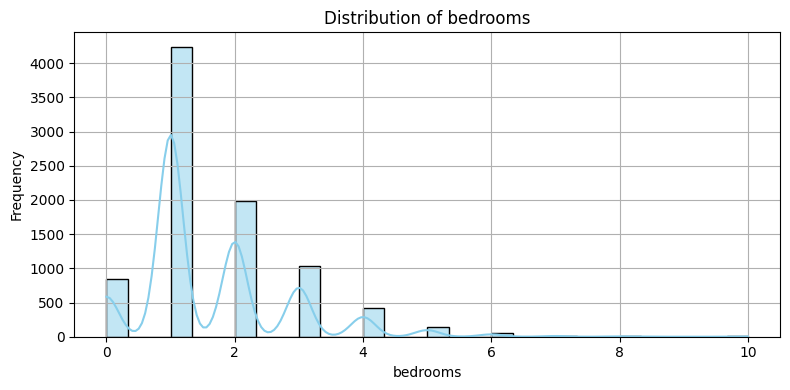

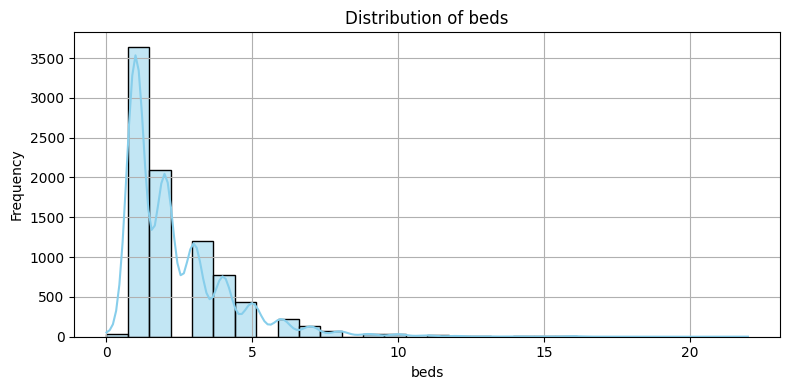

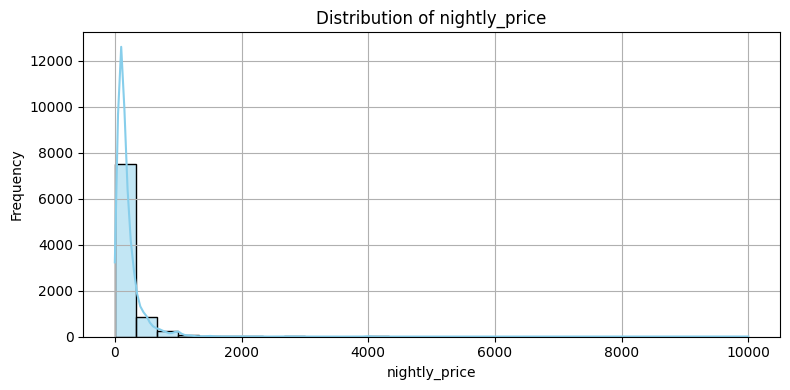

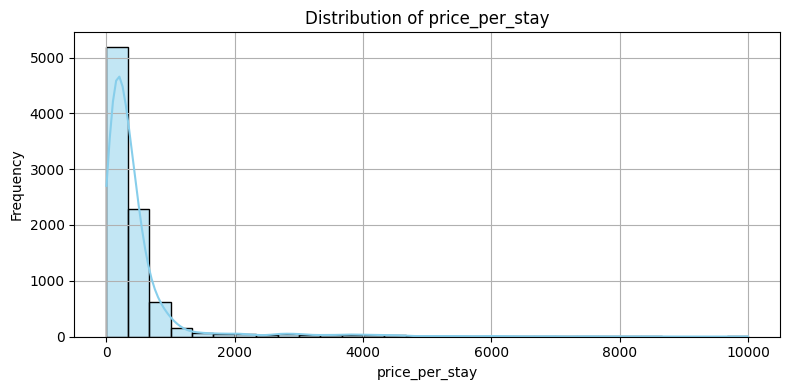

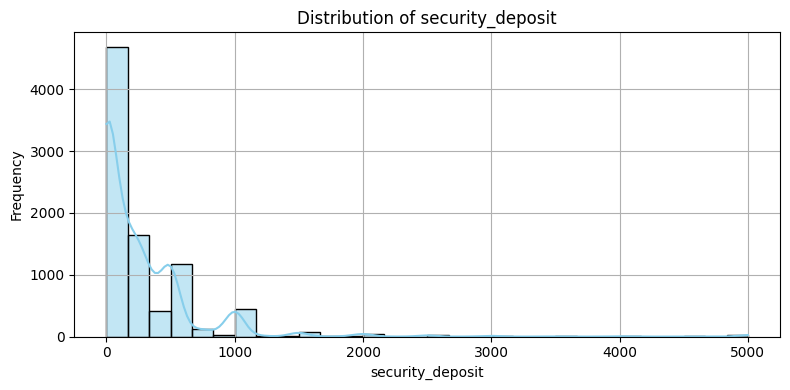

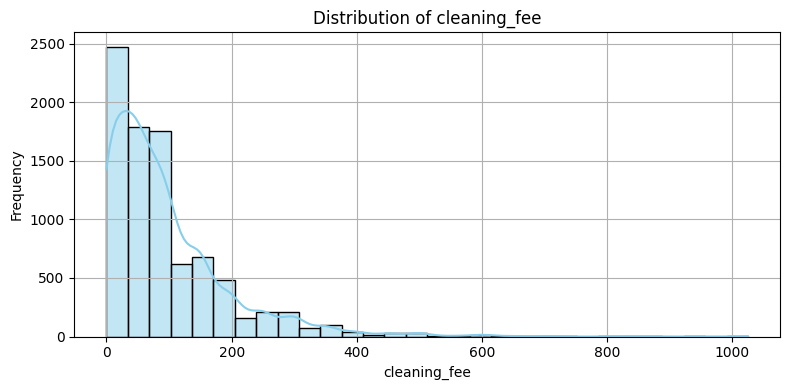

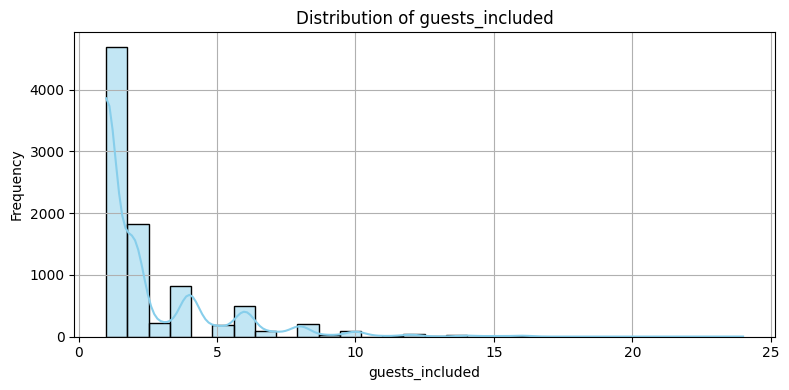

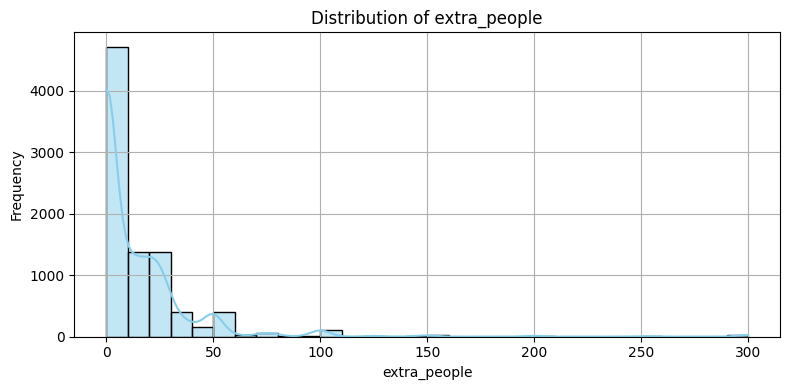

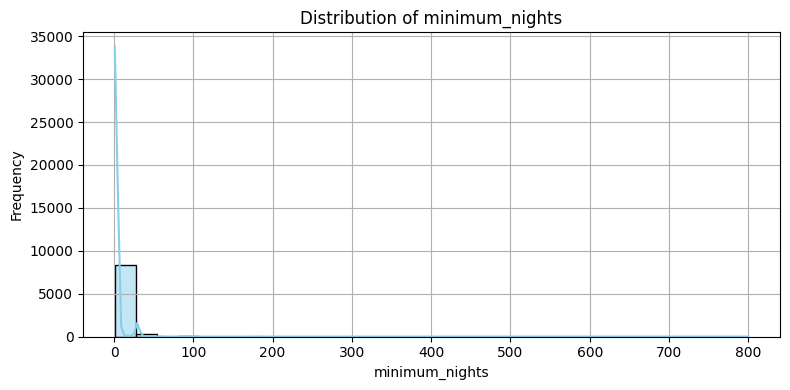

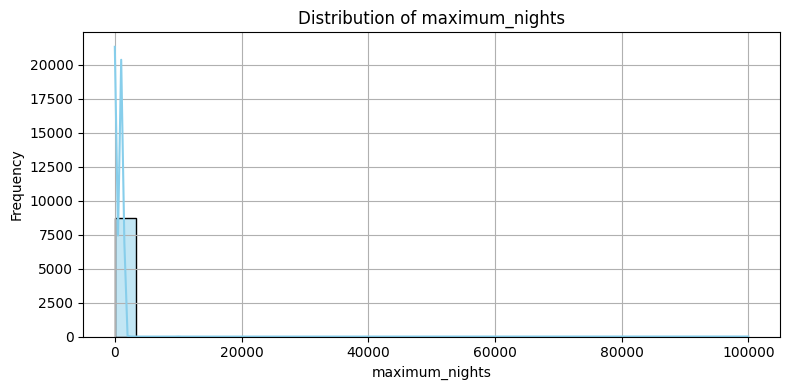

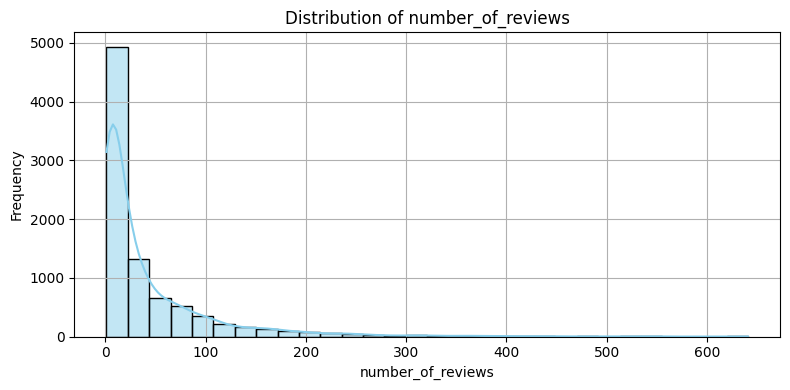

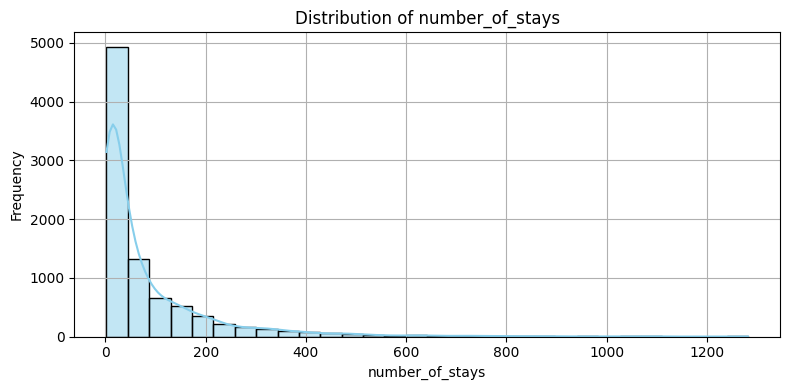

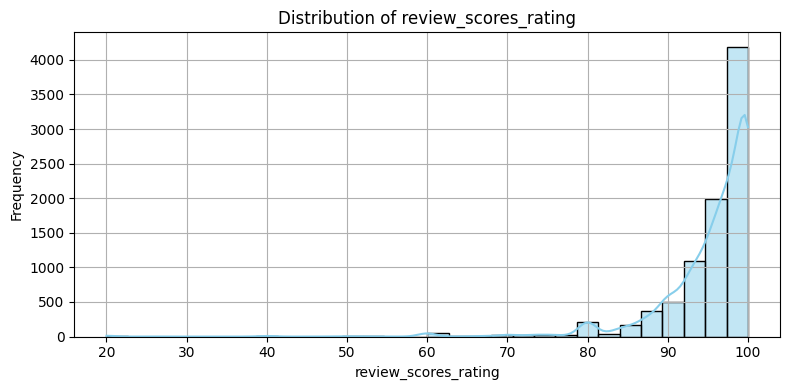

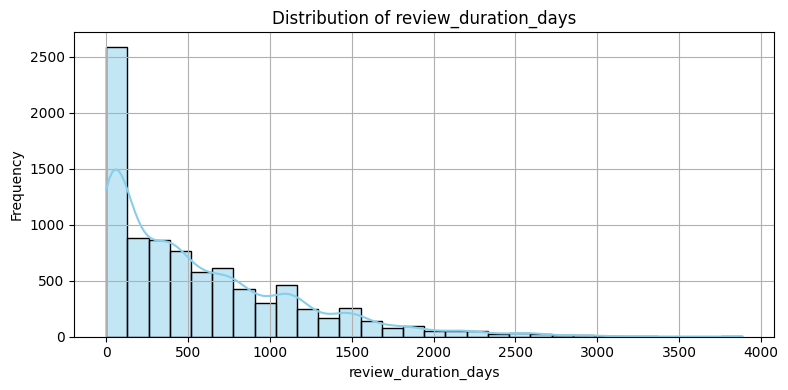

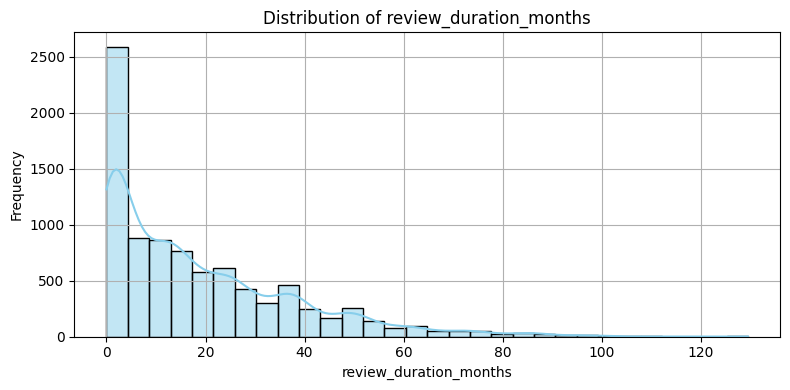

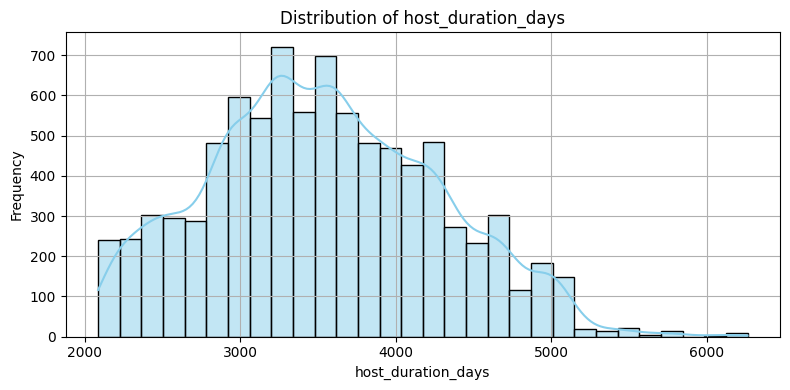

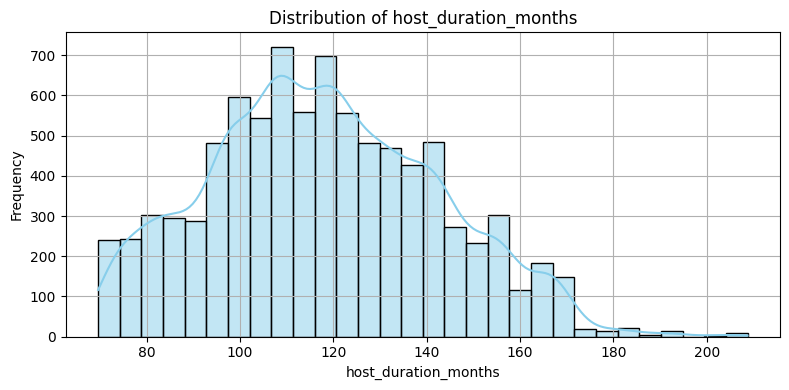

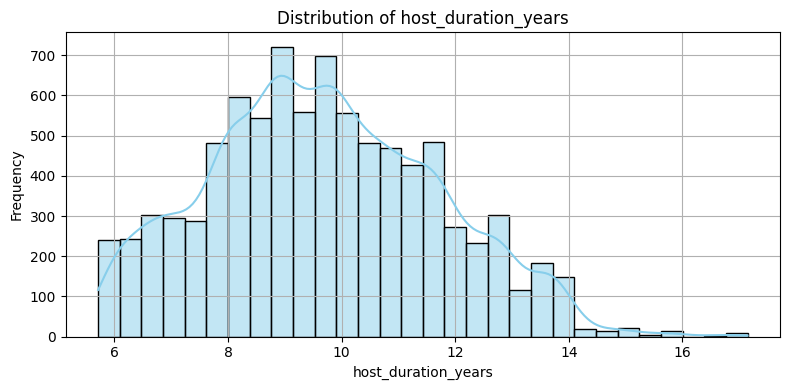

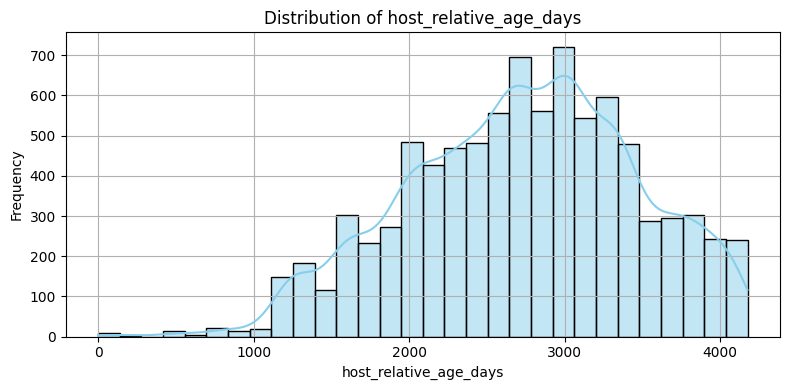

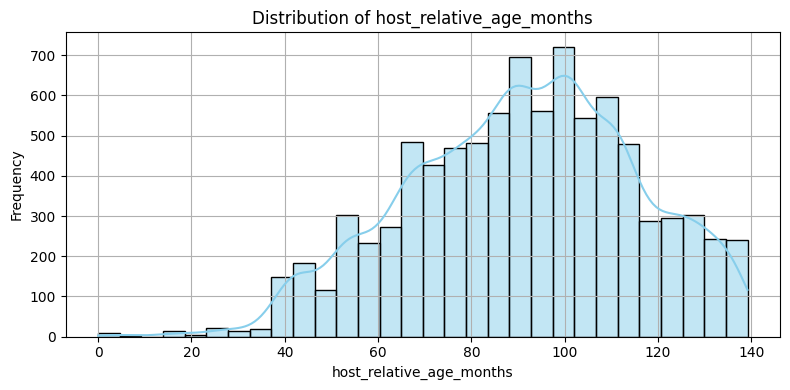

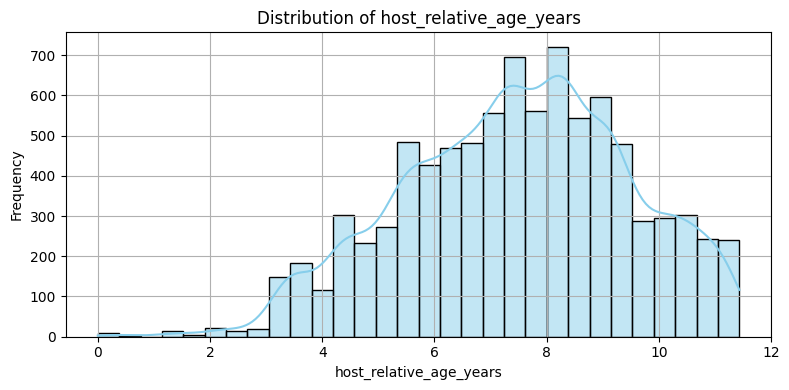

In [20]:
def plot_distributions(df, numerical_cols):
    for col in numerical_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_distributions(df, Numerical_cols)


In [21]:
def plot_distributions(df, numerical_cols):
    for col in numerical_cols:
        if pd.api.types.is_numeric_dtype(df[col]):  # Check if the column is numeric
            plt.figure(figsize=(8, 4))
            sns.histplot(df[col], kde=True, bins=30, color='skyblue')
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipping non-numeric column: {col}")  # Inform the user about skipped columns

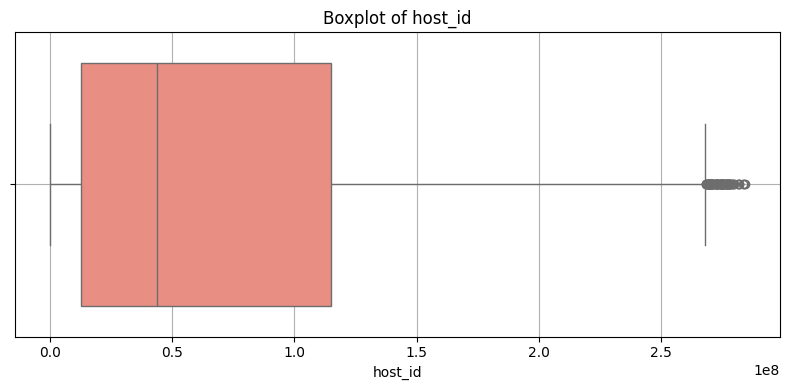

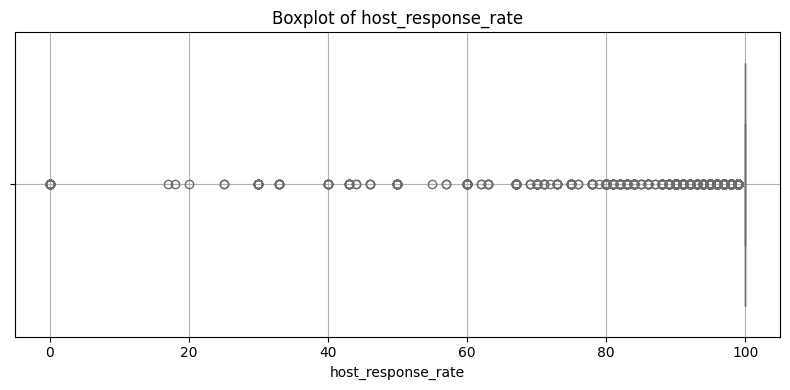

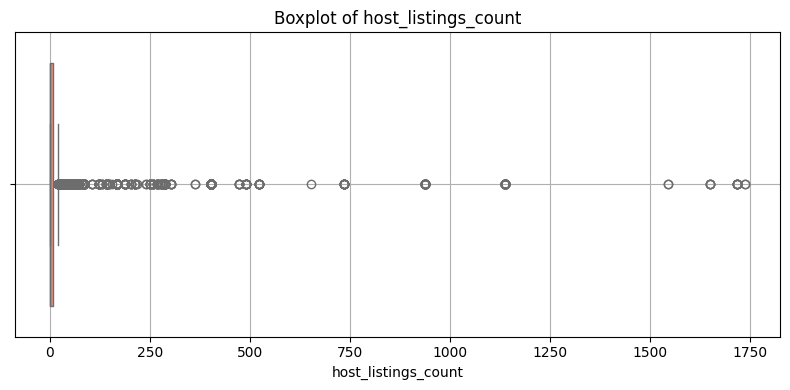

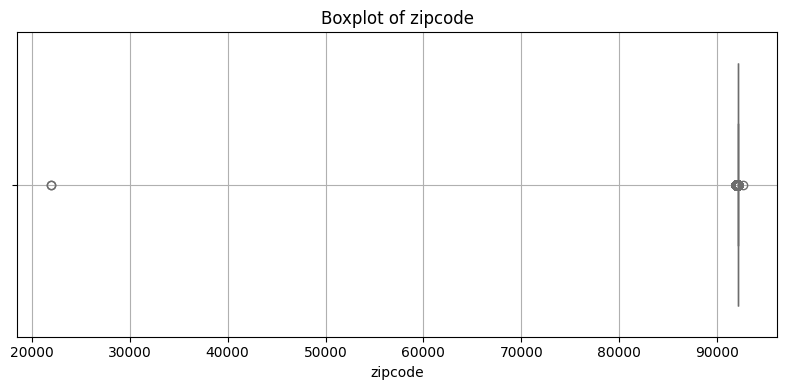

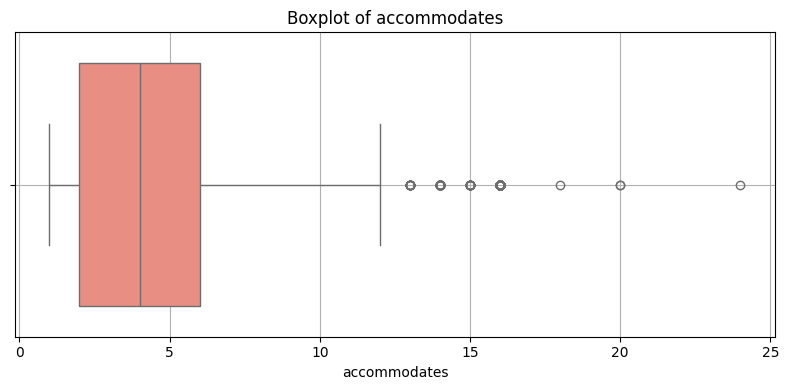

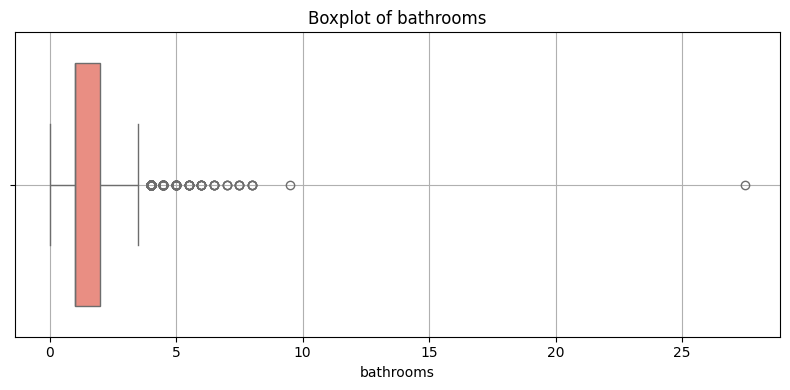

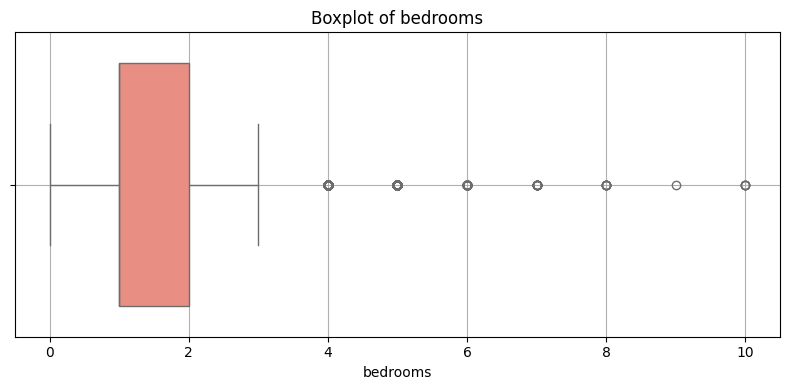

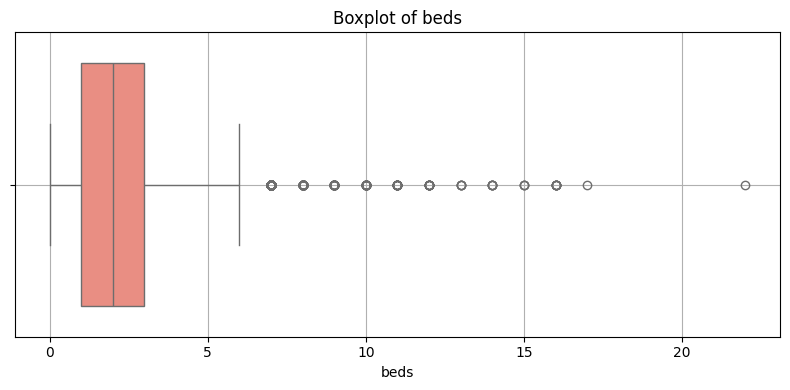

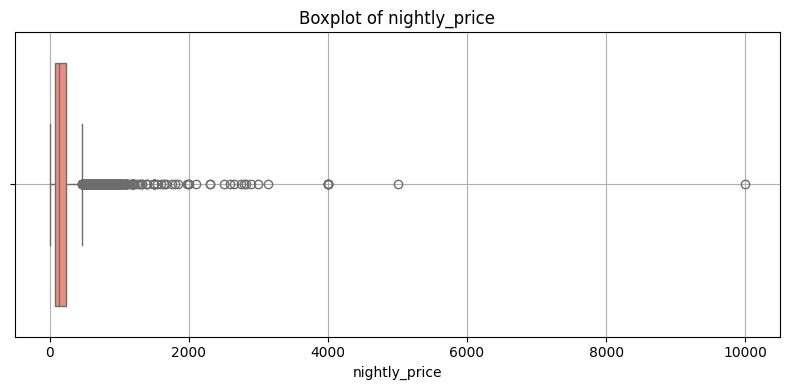

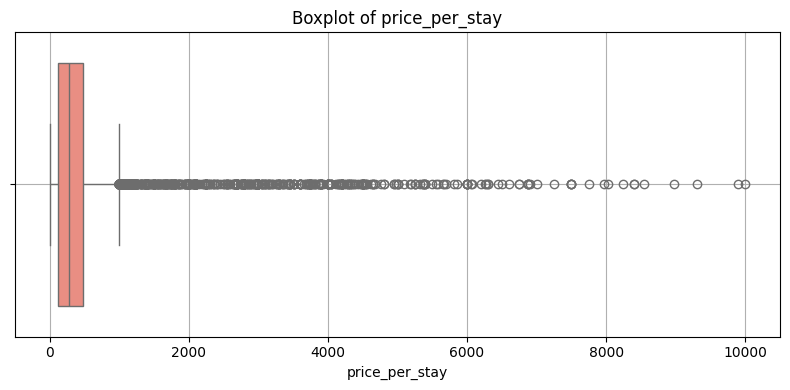

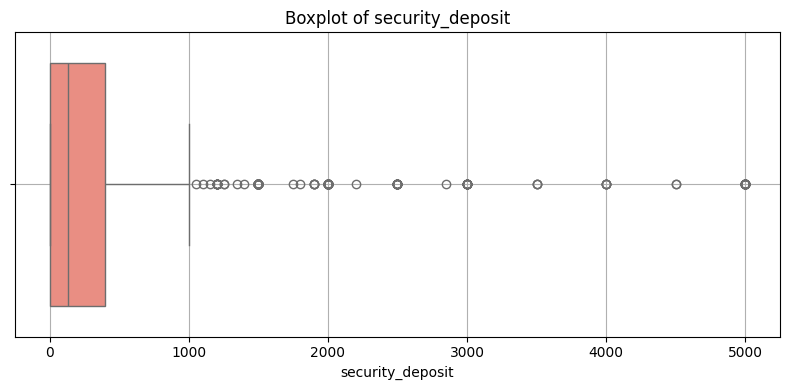

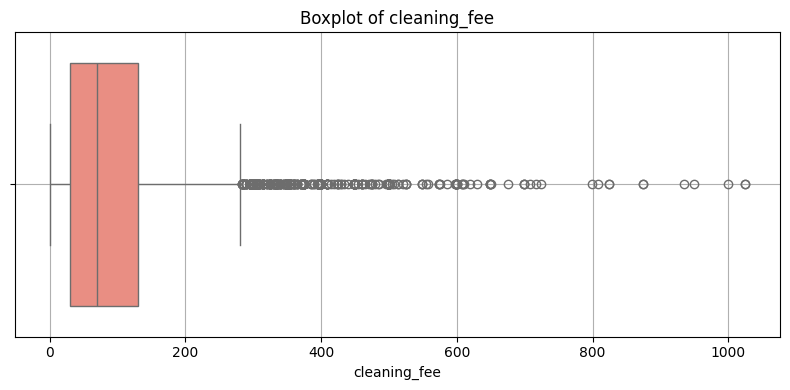

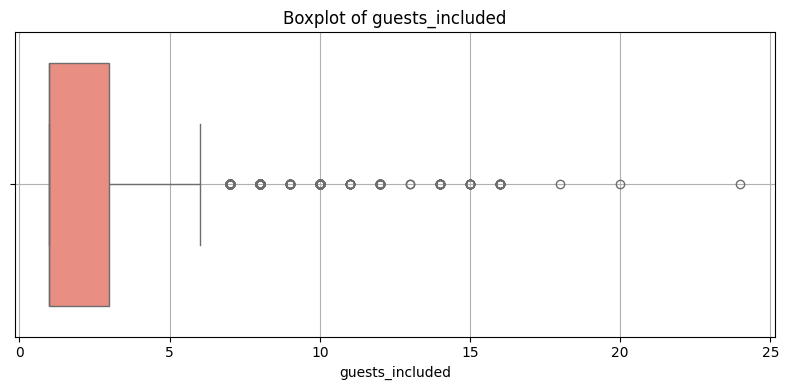

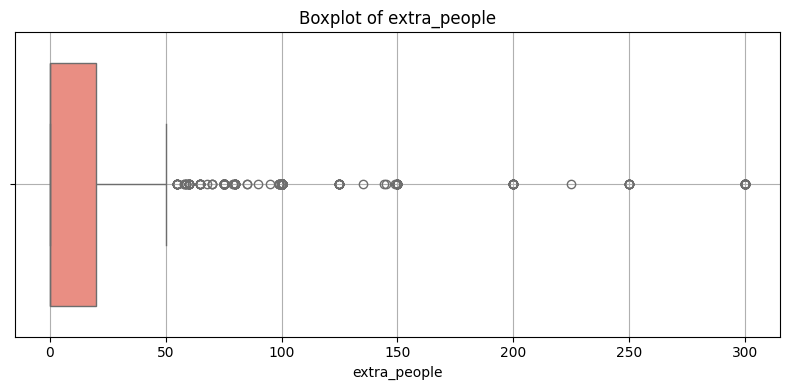

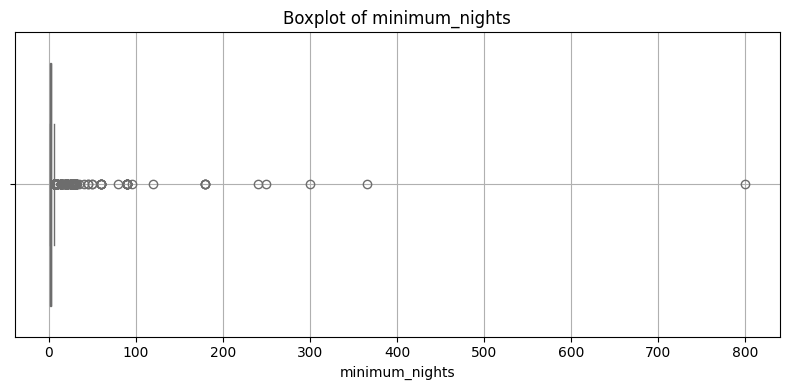

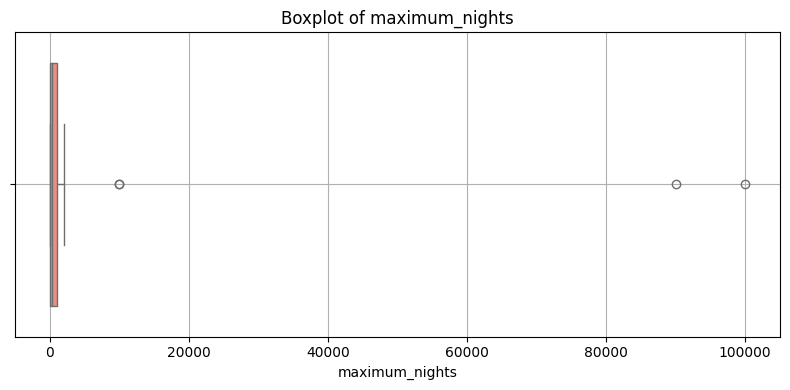

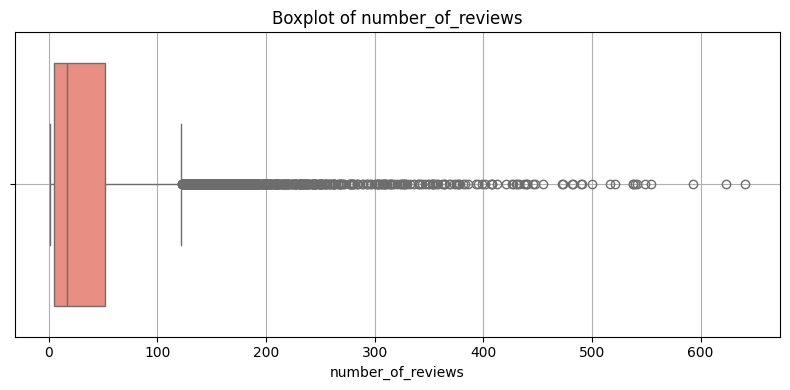

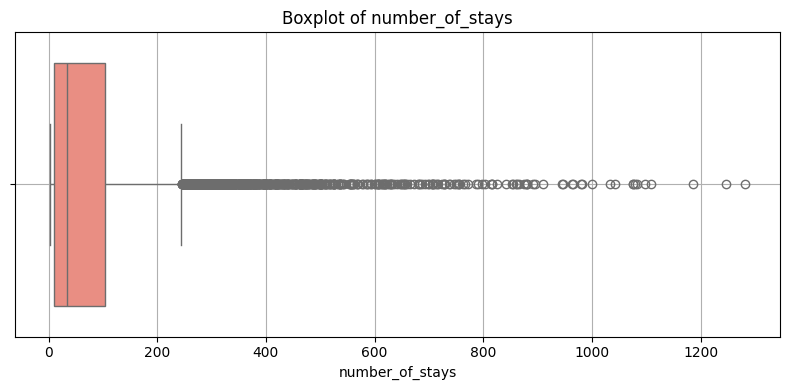

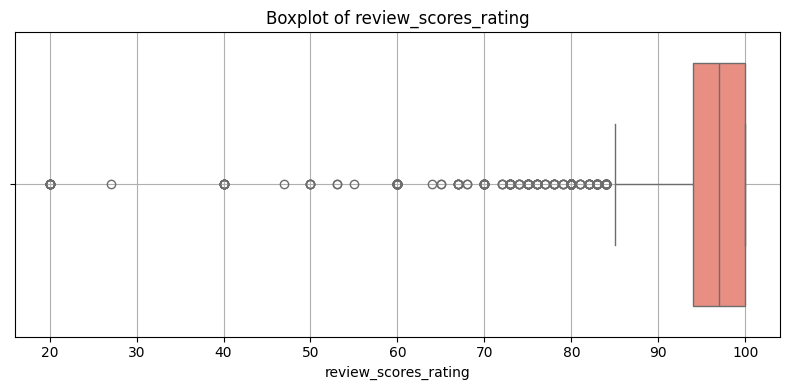

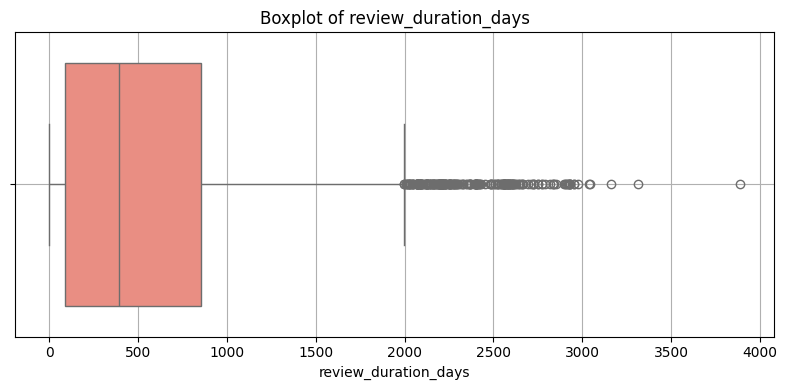

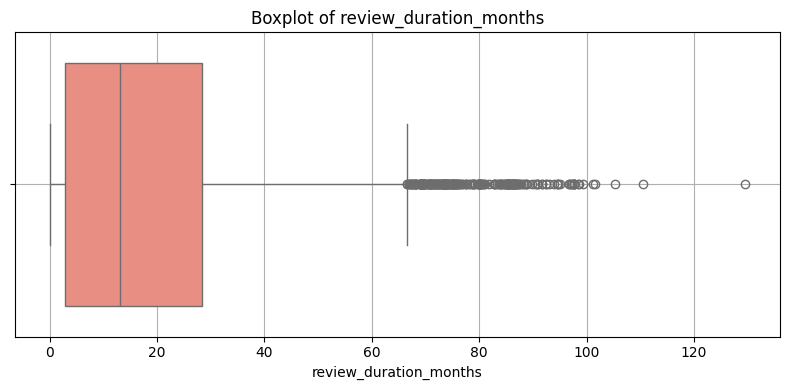

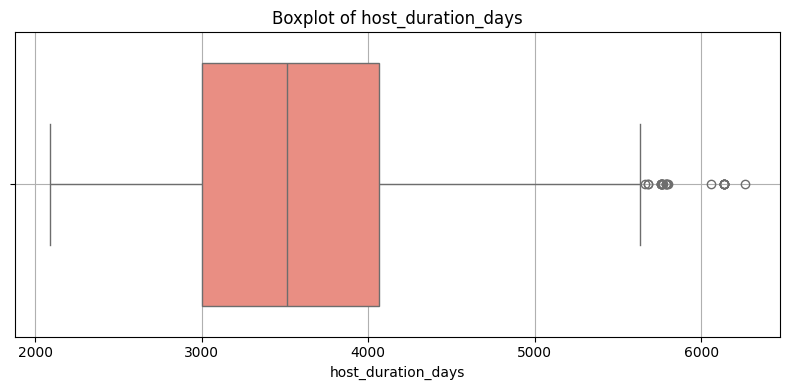

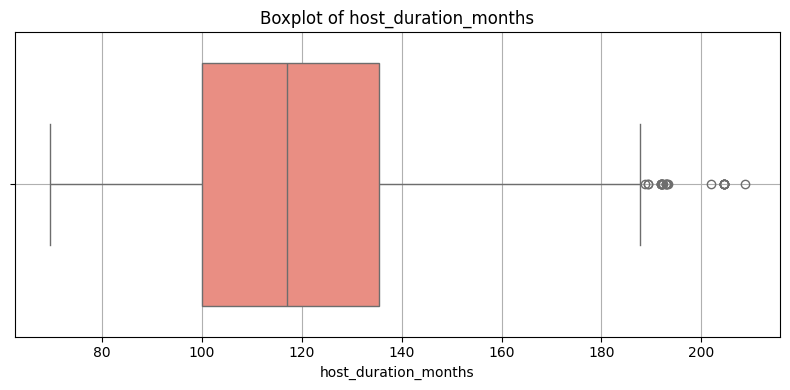

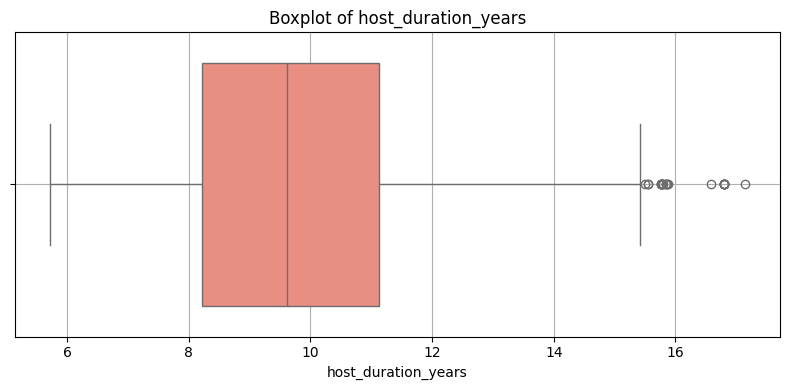

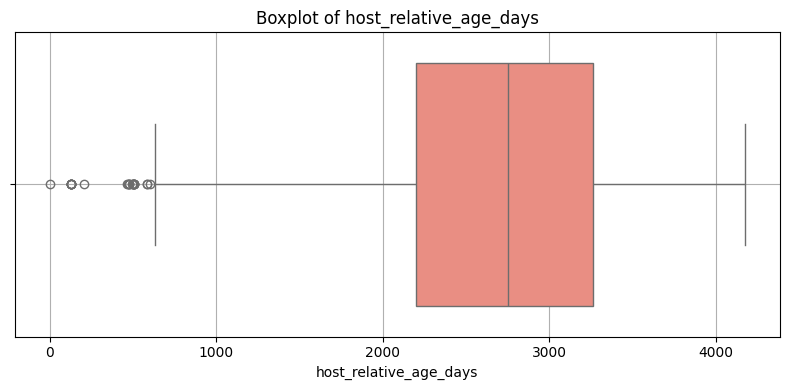

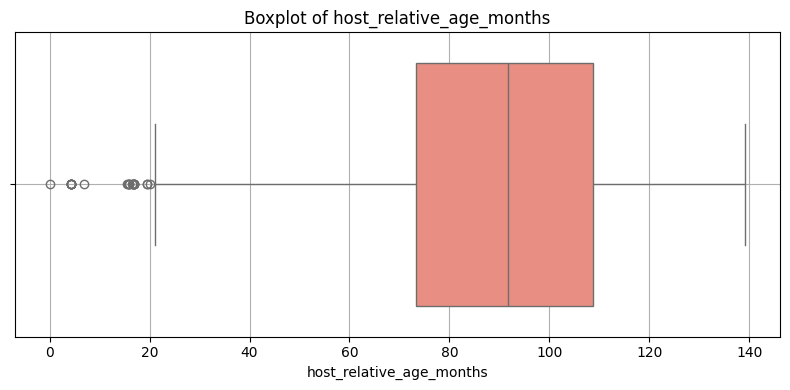

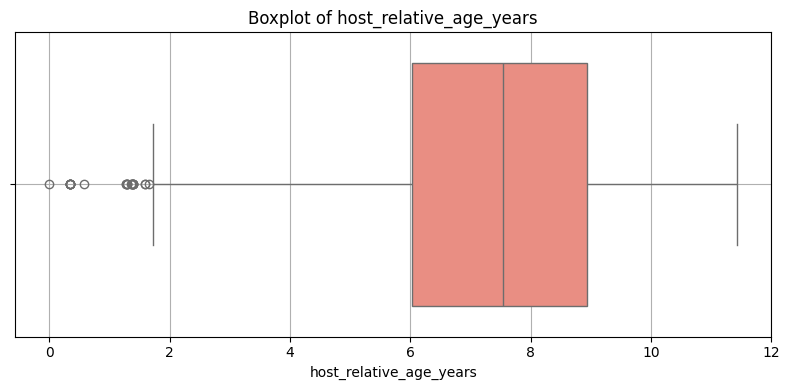

In [22]:
def plot_boxplots(df, numerical_cols):
    for col in numerical_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col], color='salmon')
        plt.title(f"Boxplot of {col}")
        plt.xlabel(col)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_boxplots(df, Numerical_cols)

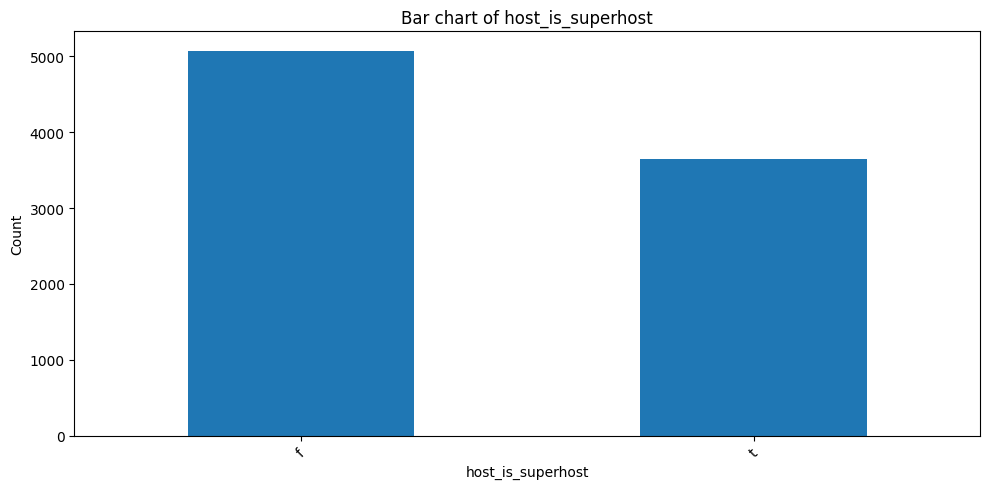

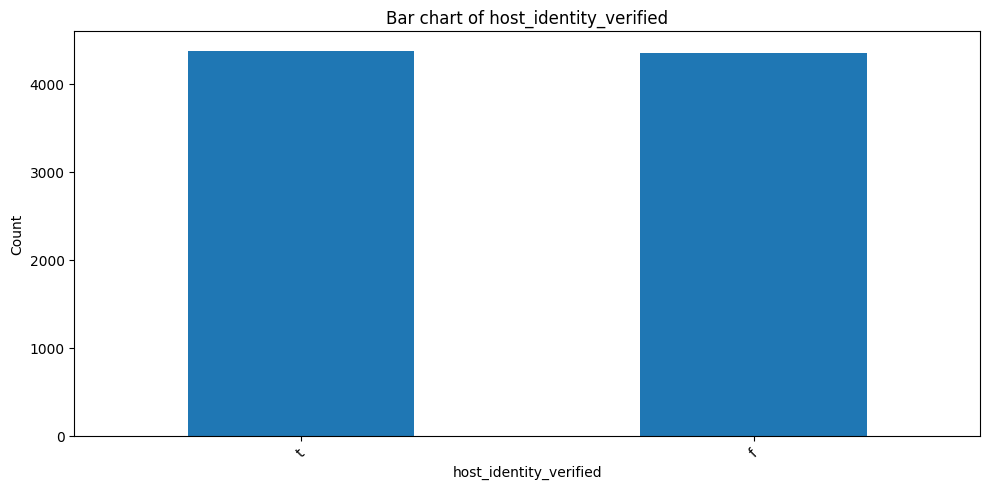

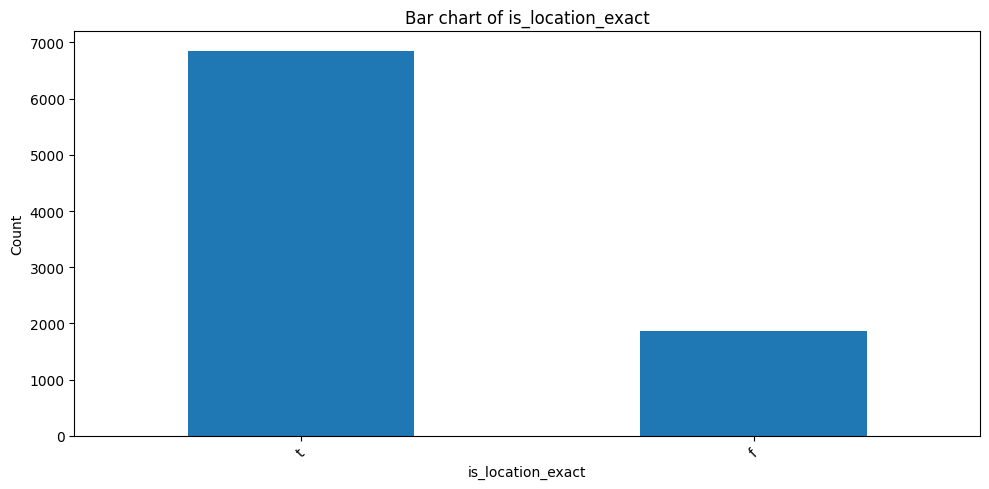

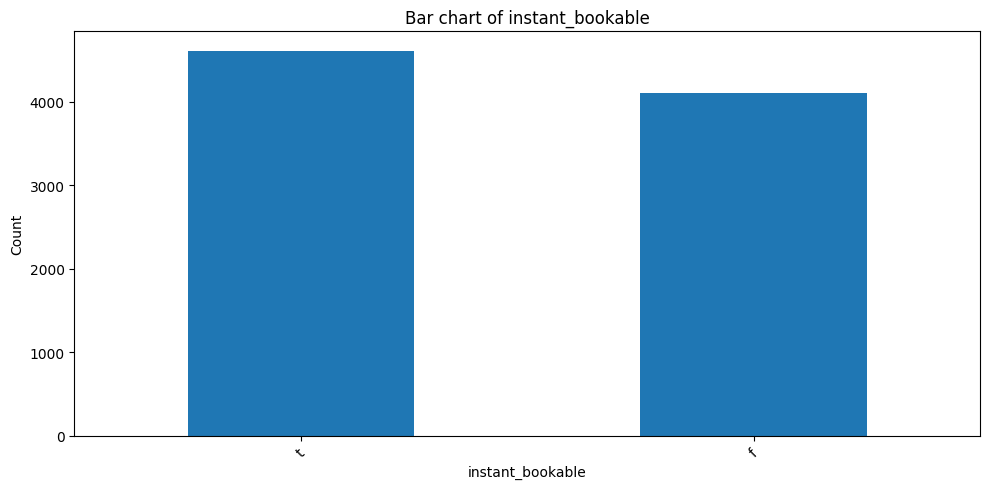

In [23]:
def plot_feature_vs_target(df, categorical_cols, target='review_scores_rating'):
    for col in categorical_cols:
        if col in df.columns:
            if df[col].nunique() > 0:
                plt.figure(figsize=(10, 5))
                df[col].value_counts().head(10).plot(kind='bar')  # top 10 categories
                plt.title(f'Bar chart of {col}')
                plt.xlabel(col)
                plt.ylabel('Count')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Skipping '{col}' due to no unique values to plot.")
        else:
            print(f"Column '{col}' not found in the DataFrame.")

plot_feature_vs_target(df, Categorical_cols)

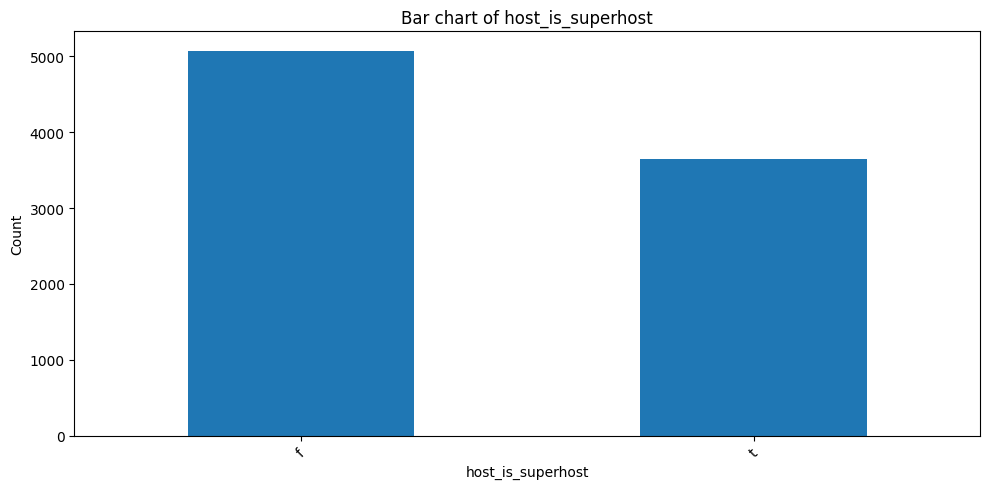

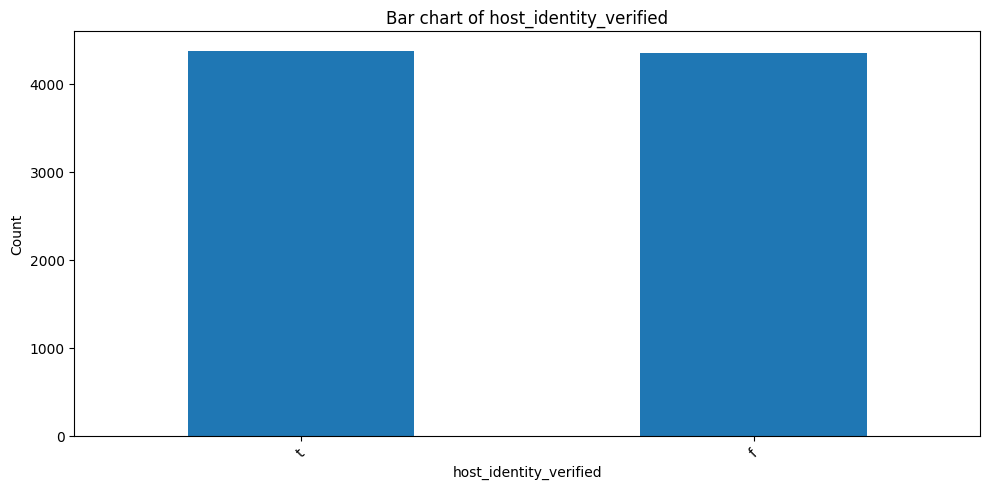

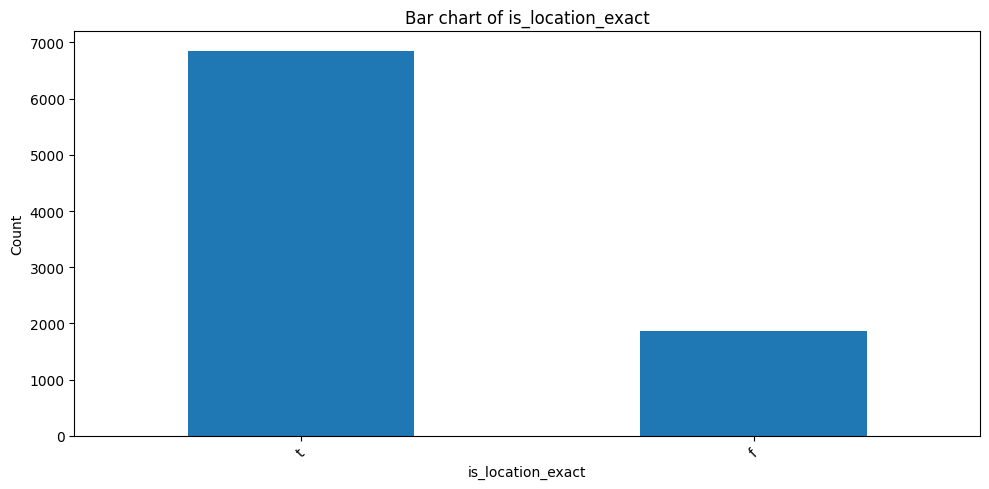

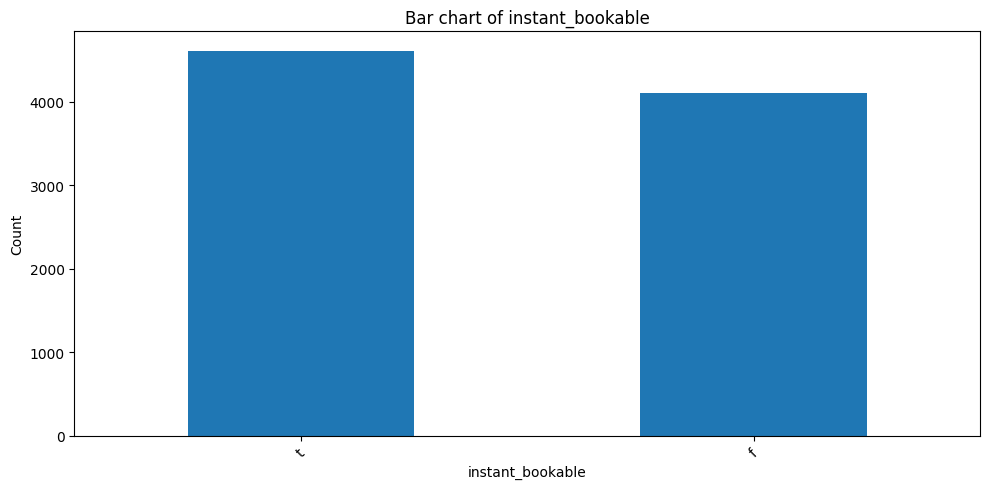

In [24]:
for col in Categorical_cols:
    # Check if the column has any unique values
    if df[col].nunique() > 0:
        plt.figure(figsize=(10, 5))
        df[col].value_counts().head(10).plot(kind='bar')  # top 10 categories
        plt.title(f'Bar chart of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping '{col}' due to no unique values to plot.")

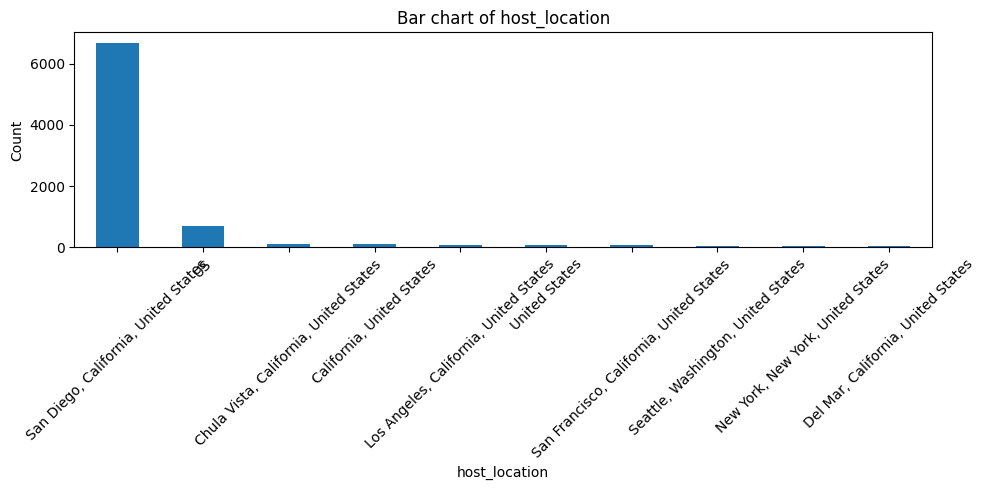

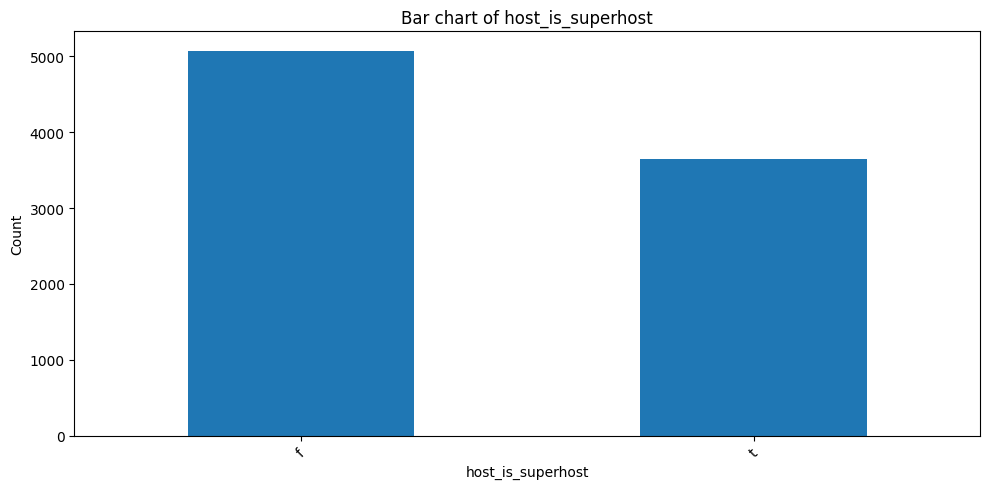

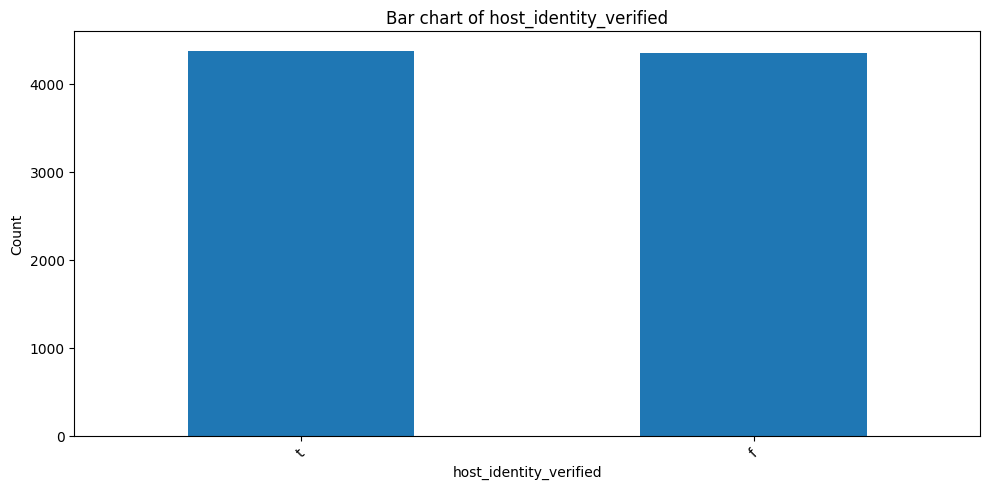

In [25]:
def plot_feature_vs_target(df, numerical_cols, target='review_scores_rating'):
   for col in categorical_cols:
    if df[col].nunique() > 0:
        plt.figure(figsize=(10, 5))
        df[col].value_counts().head(10).plot(kind='bar')  # top 10 categories
        plt.title(f'Bar chart of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping '{col}' due to no unique values to plot.")

plot_feature_vs_target(df, Numerical_cols)


# **Handling outliers**

In [26]:
def handle_outliers_iqr(df, numerical_cols, method='cap'):
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        if method == 'remove':
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        elif method == 'cap':
            df[col] = np.where(df[col] < lower_bound, lower_bound,
                      np.where(df[col] > upper_bound, upper_bound, df[col]))
    return df


In [27]:
df = handle_outliers_iqr(df, Numerical_cols, method='cap')  # or 'remove'


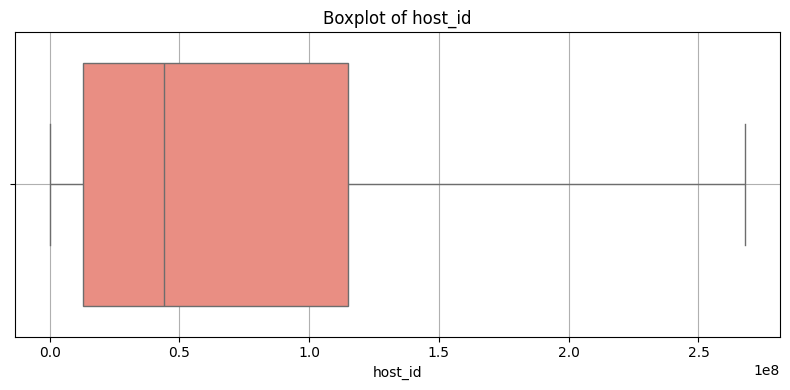

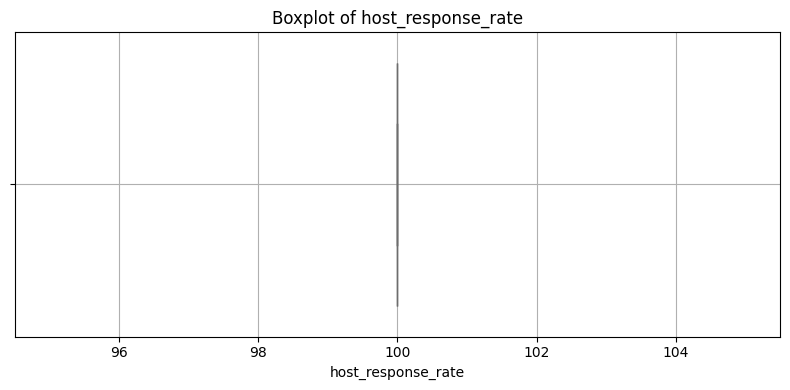

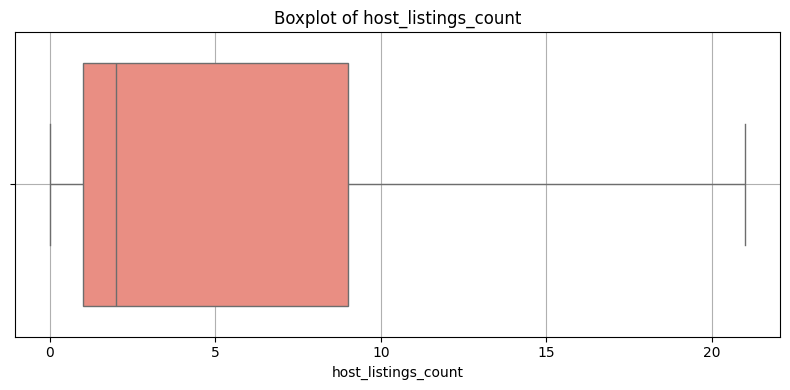

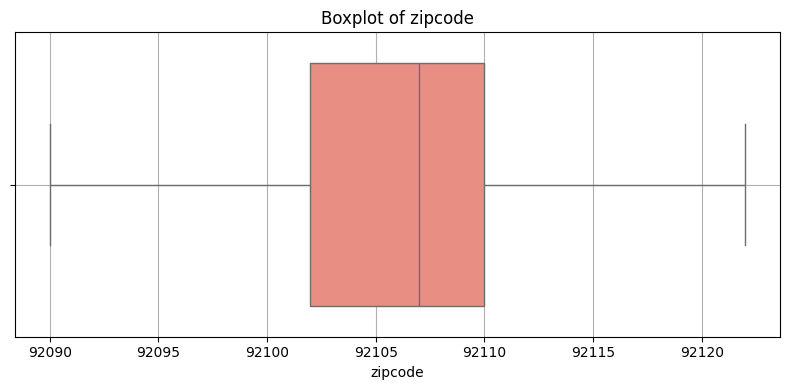

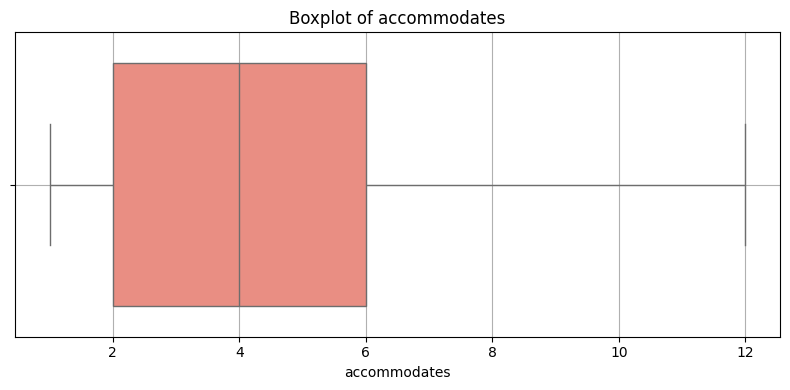

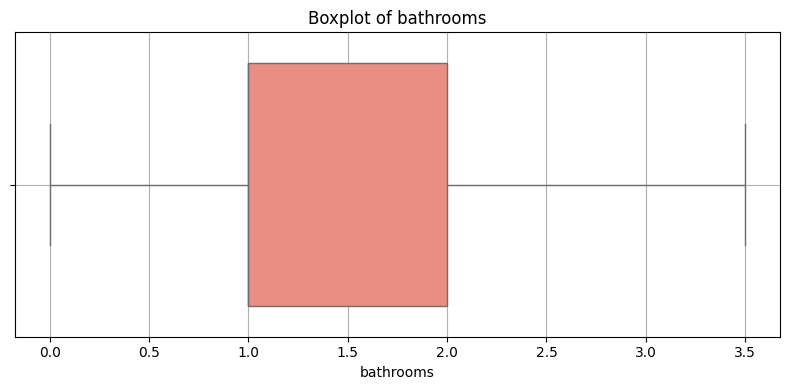

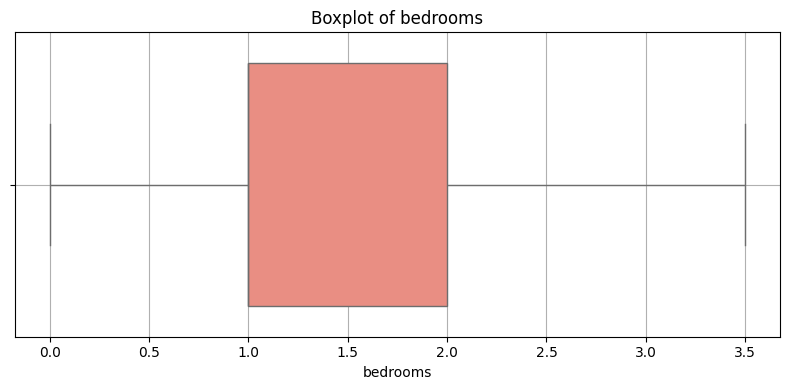

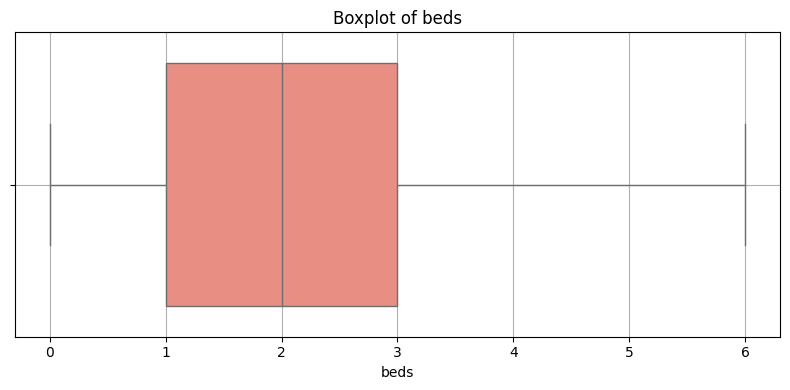

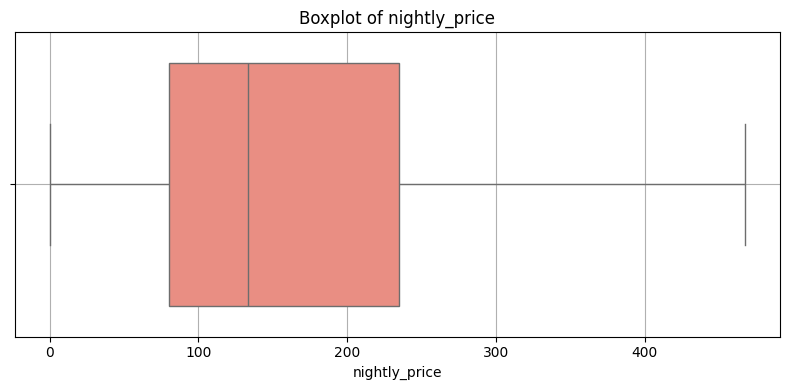

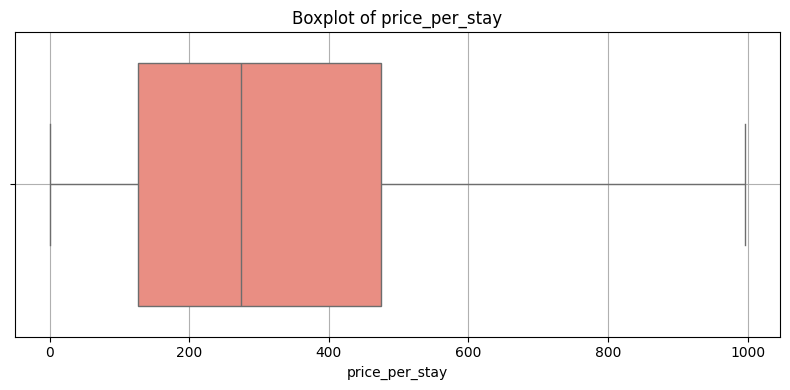

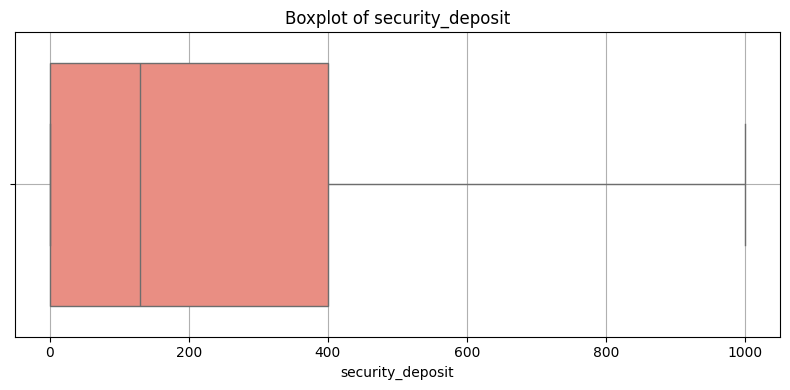

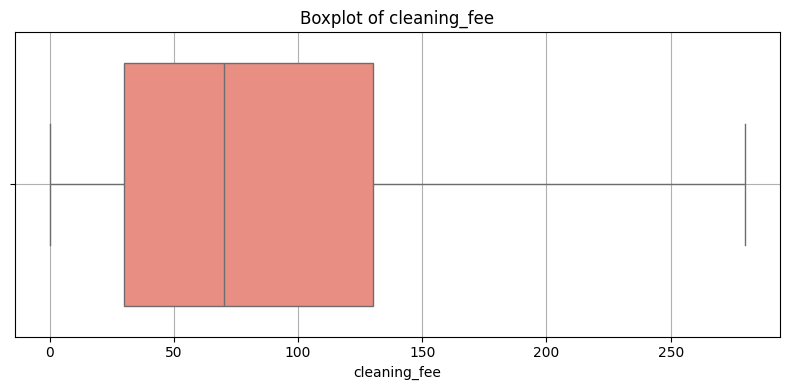

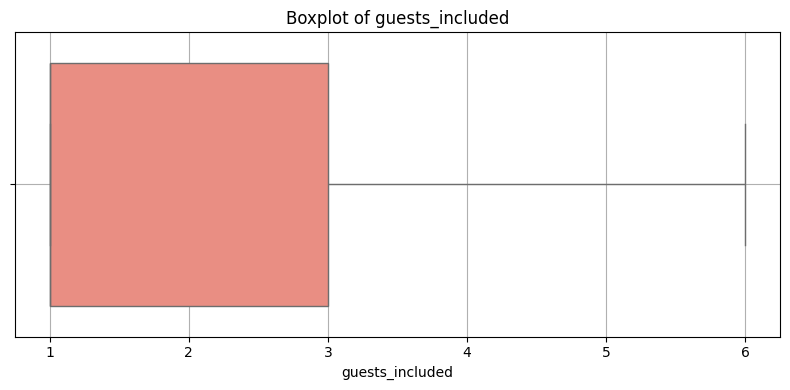

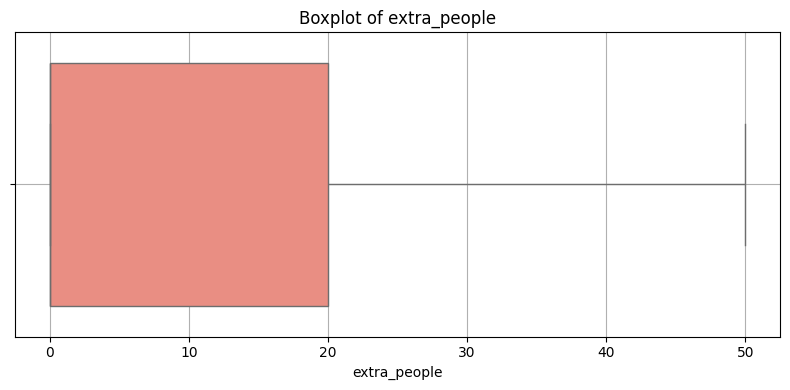

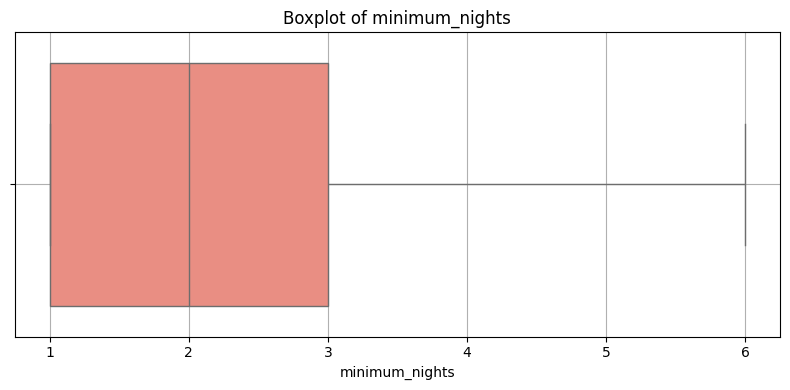

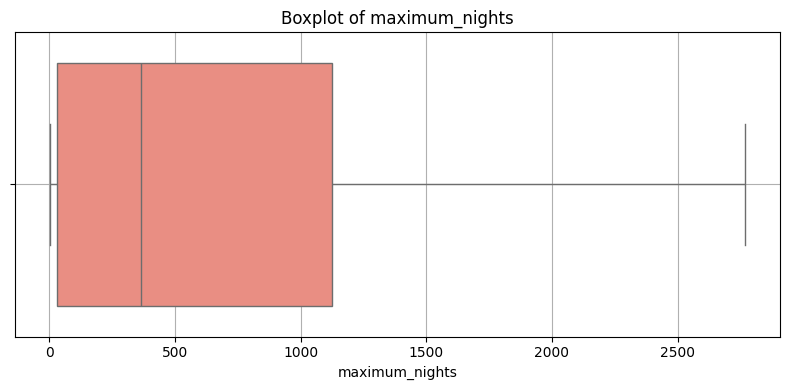

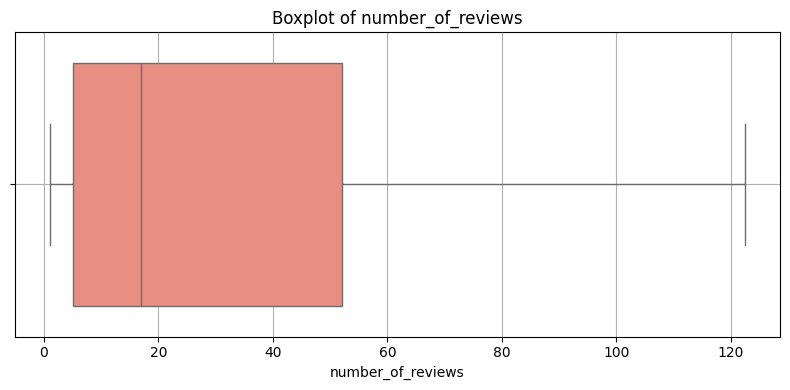

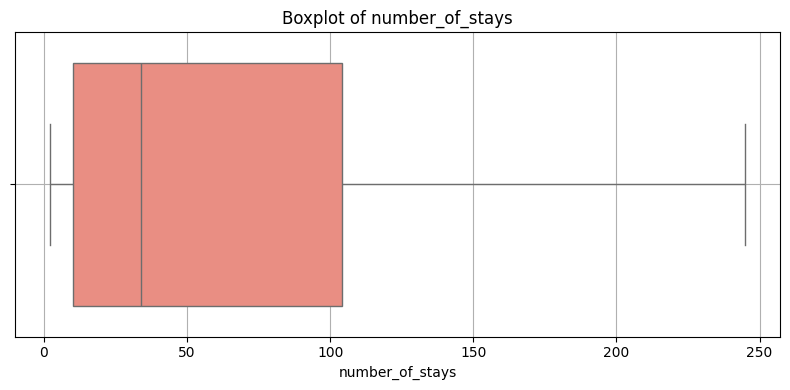

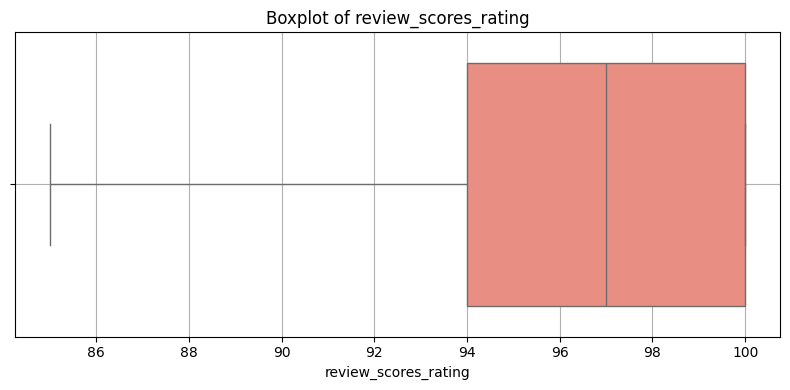

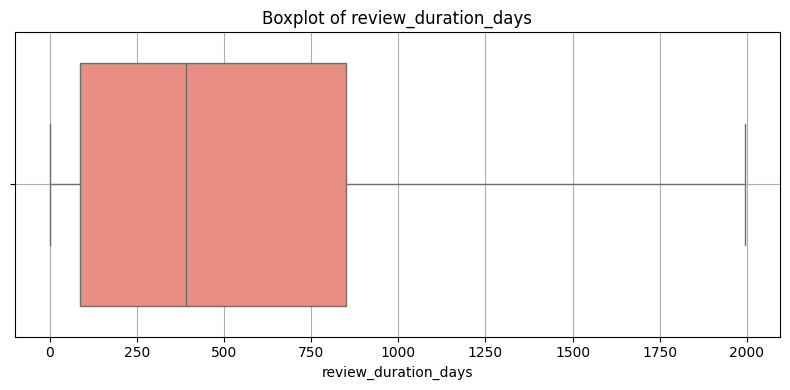

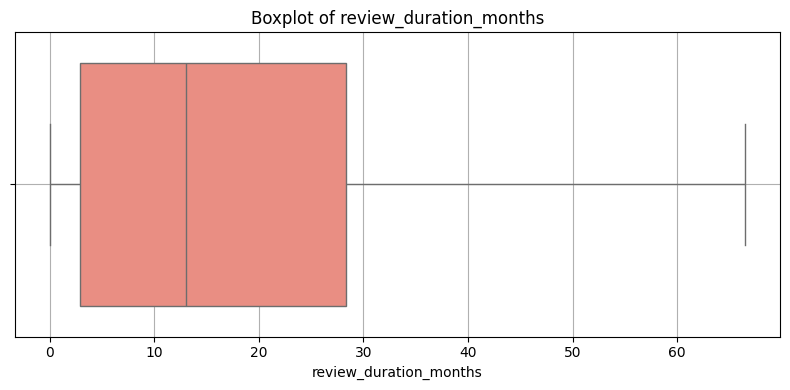

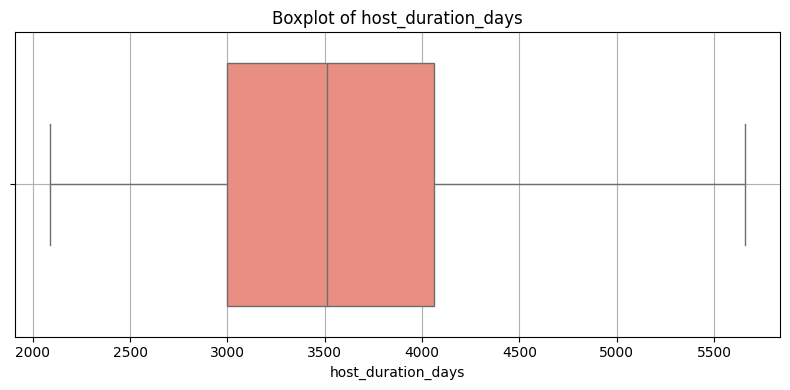

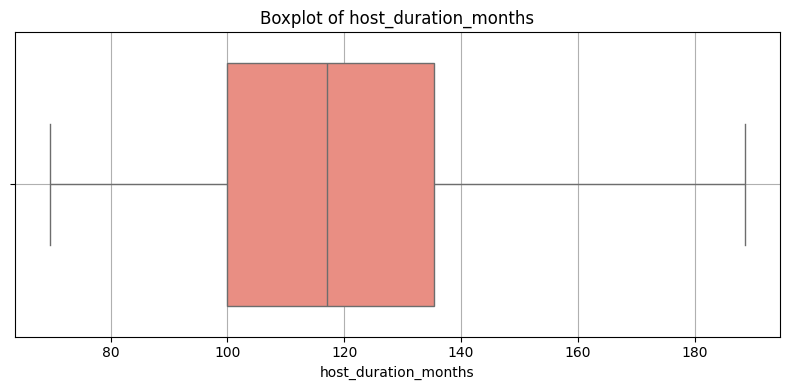

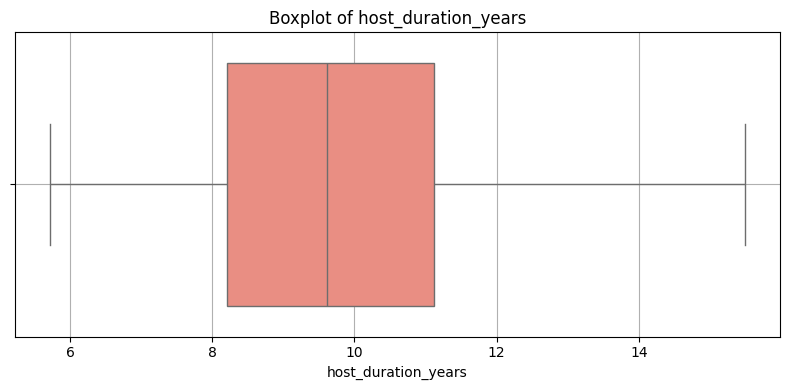

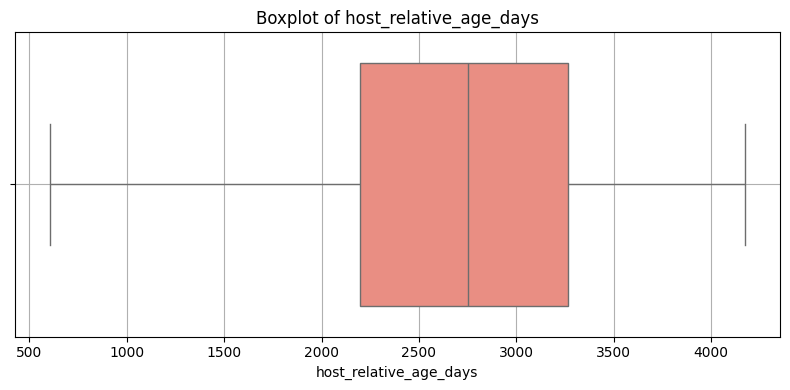

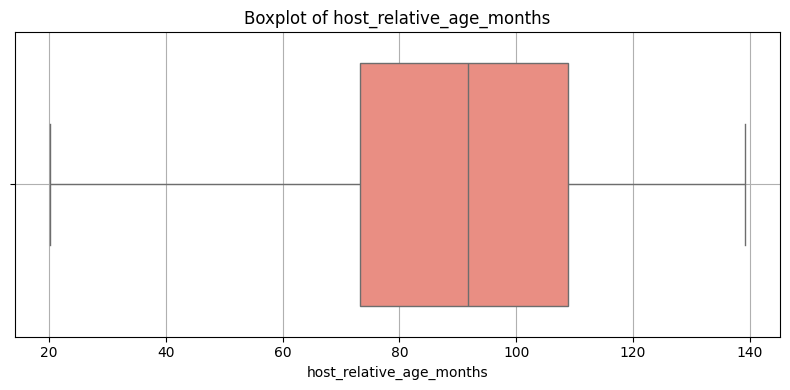

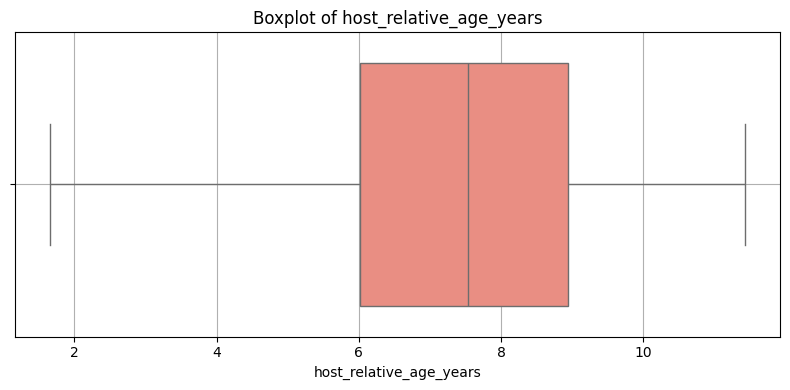

In [28]:
plot_boxplots(df, Numerical_cols)

# **Text Preprocessing & Feature Engineering**

In [29]:
def parse_amenities(amenities_str):
    amenities_str = amenities_str.strip('{}')
    items = [item.strip().strip('"') for item in amenities_str.split(',')]
    return items

df['amenities_parsed'] = df['amenities'].apply(parse_amenities)

amenity_categories = {
    'Basic Necessities': {'Heating', 'Hot water', 'Smoke detector', 'Carbon monoxide detector'},
    'Comfort/Convenience': {'Air conditioning', 'Kitchen', 'Iron', 'Laptop friendly workspace', 'Essentials', 'Hangers'},
    'Technology': {'TV', 'Wifi'},
    'Safety': {'Smoke detector', 'Carbon monoxide detector', 'Lock on bedroom door'},
    'Recreation': {'Pool', 'Gym', 'Hot tub'},
    'Parking': {'Free parking on premises'},
    'Accessibility': {'Elevator', 'Private entrance'}
}

def categorize_amenities(amenities_list):
    categorized = {category: [] for category in amenity_categories}
    for amenity in amenities_list:
        for category, items in amenity_categories.items():
            if amenity in items:
                categorized[category].append(amenity)
    return categorized

df['amenities_categorized'] = df['amenities_parsed'].apply(categorize_amenities)


def create_binary_features(amenities_list):
    binary_features = {}
    all_amenities = set(amenities_list)
    for category, items in amenity_categories.items():
        for item in items:
            binary_features[f'has_{item.lower().replace(" ", "_")}'] = 1 if item in all_amenities else 0
    return binary_features

binary_features_df = df['amenities_parsed'].apply(create_binary_features).apply(pd.Series)


df = df.join(binary_features_df)

df = df.drop(columns=[col for col in ['amenities', 'amenities_parsed', 'amenities_categorized'] if col in df.columns])

print(df.columns)

Index(['description', 'neighborhood_overview', 'notes', 'transit', 'access',
       'interaction', 'house_rules', 'host_id', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count', 'host_identity_verified',
       'neighbourhood_cleansed', 'zipcode', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'nightly_price', 'price_per_stay', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'number_of_stays',
       'review_scores_rating', 'instant_bookable', 'cancellation_policy',
       'review_duration_days', 'review_duration_months', 'host_duration_days',
       'host_duration_months', 'host_duration_years', 'host_relative_age_days',
       'host_relative_age_months', 'host_relative_age_years', 'has_heating',
       'has_smoke_detector', '

In [30]:
def get_text_columns(df, sample_ratio=0.3, min_avg_len=5, min_unique=3):
    text_columns = []

    for col in df.columns:
        sample = df[col].dropna().sample(frac=min(sample_ratio, 1.0), random_state=42)

        is_text = sample.apply(lambda x: isinstance(x, str) and not x.isnumeric()).mean() > 0.8
        avg_len = sample.apply(lambda x: len(x) if isinstance(x, str) else 0).mean()
        num_unique = df[col].nunique()

        if is_text and avg_len > min_avg_len and num_unique >= min_unique:
            text_columns.append(col)

    return text_columns


text_columns = get_text_columns(df)
print("Text columns in the DataFrame:", text_columns)


Text columns in the DataFrame: ['description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_location', 'host_about', 'host_response_time', 'host_neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type', 'cancellation_policy']


In [31]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))

    # tokenize with 'english' language
    tokens = word_tokenize(text, language='english')
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)
preprocessed_columns = [f"{col}_cleaned" for col in text_columns]
for col in text_columns:
    df[f"{col}_cleaned"] = df[col].apply(preprocess_text)

text_columns.remove('host_response_time')
df = df.drop(columns=text_columns)
df.columns


Index(['host_id', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'zipcode', 'is_location_exact', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'nightly_price', 'price_per_stay', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'number_of_stays',
       'review_scores_rating', 'instant_bookable', 'review_duration_days',
       'review_duration_months', 'host_duration_days', 'host_duration_months',
       'host_duration_years', 'host_relative_age_days',
       'host_relative_age_months', 'host_relative_age_years', 'has_heating',
       'has_smoke_detector', 'has_hot_water', 'has_carbon_monoxide_detector',
       'has_essentials', 'has_hangers', 'has_iron', 'has_kitchen',
       'has_laptop_friendly_workspace', 'has_air_conditioning', 'has_tv',
       'has_wifi', 'has_lock_on_bedroom_door', 'has_pool', 'has_

In [32]:
def calculate_text_importance(df, text_columns, target_col, max_features=1000):
    df = df.copy()
    importance_scores = {}

    for col in text_columns:
        vectorizer = TfidfVectorizer(max_features=max_features)
        try:
            tfidf = vectorizer.fit_transform(df[col].astype(str))
        except ValueError:
            df[col] = 0.0
            importance_scores[col] = 0.0
            continue

        doc_variances = np.array(tfidf.todense()).var(axis=1).flatten()
        df[col] = doc_variances

        term_variances = np.array(tfidf.todense()).var(axis=0).mean()

        correlations = []
        for i in range(tfidf.shape[1]):
            term_scores = tfidf[:, i].toarray().flatten()
            with np.errstate(invalid='ignore'):
                corr, _ = spearmanr(term_scores, df[target_col].values)
            correlations.append(abs(corr))

        avg_corr = np.nanmean(correlations) if correlations else 0.0

        importance = (term_variances + avg_corr) / 2
        importance_scores[col] = importance

    return df, importance_scores

TF_IDF,importance_scores = calculate_text_importance(df, preprocessed_columns, target_col = 'review_scores_rating',max_features=1000)
print("Importance Scores:", importance_scores)

Importance Scores: {'description_cleaned': np.float64(0.008284694852623268), 'neighborhood_overview_cleaned': np.float64(0.008041002426727803), 'notes_cleaned': np.float64(0.008501115614400678), 'transit_cleaned': np.float64(0.007044751590363718), 'access_cleaned': np.float64(0.00731833198811183), 'interaction_cleaned': np.float64(0.007652238625721967), 'house_rules_cleaned': np.float64(0.012970457716579962), 'host_location_cleaned': np.float64(0.006192850189603226), 'host_about_cleaned': np.float64(0.010128483753474533), 'host_response_time_cleaned': np.float64(0.03131049797138388), 'host_neighbourhood_cleaned': np.float64(0.00976865945581418), 'neighbourhood_cleansed_cleaned': np.float64(0.011120922270053069), 'property_type_cleaned': np.float64(0.017664003341602307), 'room_type_cleaned': np.float64(0.0766420281442351), 'cancellation_policy_cleaned': np.float64(0.09208417819542031)}


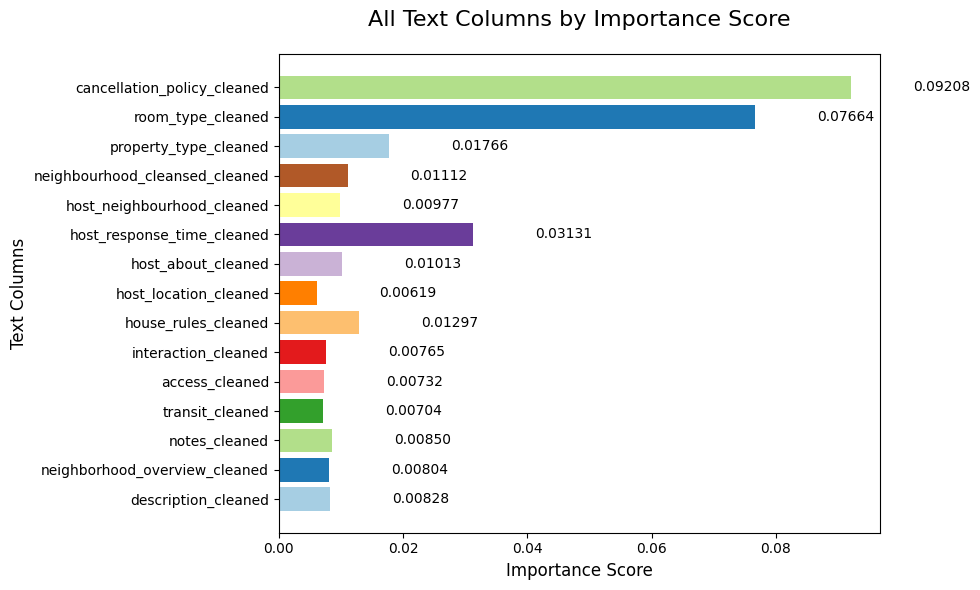

In [33]:
def visualize(importance_scores):

    fig, ax = plt.subplots(figsize=(10, 6))

    columns = list(importance_scores.keys())
    values = list(importance_scores.values())

    bars = ax.barh(columns, values, color=plt.cm.Paired.colors)
    ax.set_title("All Text Columns by Importance Score", fontsize=16, pad=20)
    ax.set_xlabel("Importance Score", fontsize=12)
    ax.set_ylabel("Text Columns", fontsize=12)
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01,bar.get_y() + bar.get_height() / 2,f"{width:.5f}",ha='left',va='center',fontsize=10)

    plt.tight_layout()
    plt.show()


visualize(importance_scores)

In [34]:
df['host_location_cleaned'] = df['host_location_cleaned'].astype(str)

# Exact match
target_location = 'San Diego, California, United States'
match_mask = df['host_location_cleaned'].str.strip() == target_location

# Calculate percentage
percentage = match_mask.mean() * 100

print(f"Percentage of entries that are exactly '{target_location}': {percentage:.2f}%")


Percentage of entries that are exactly 'San Diego, California, United States': 0.00%


# **Feature Selection**


---

Numerical Selection

---




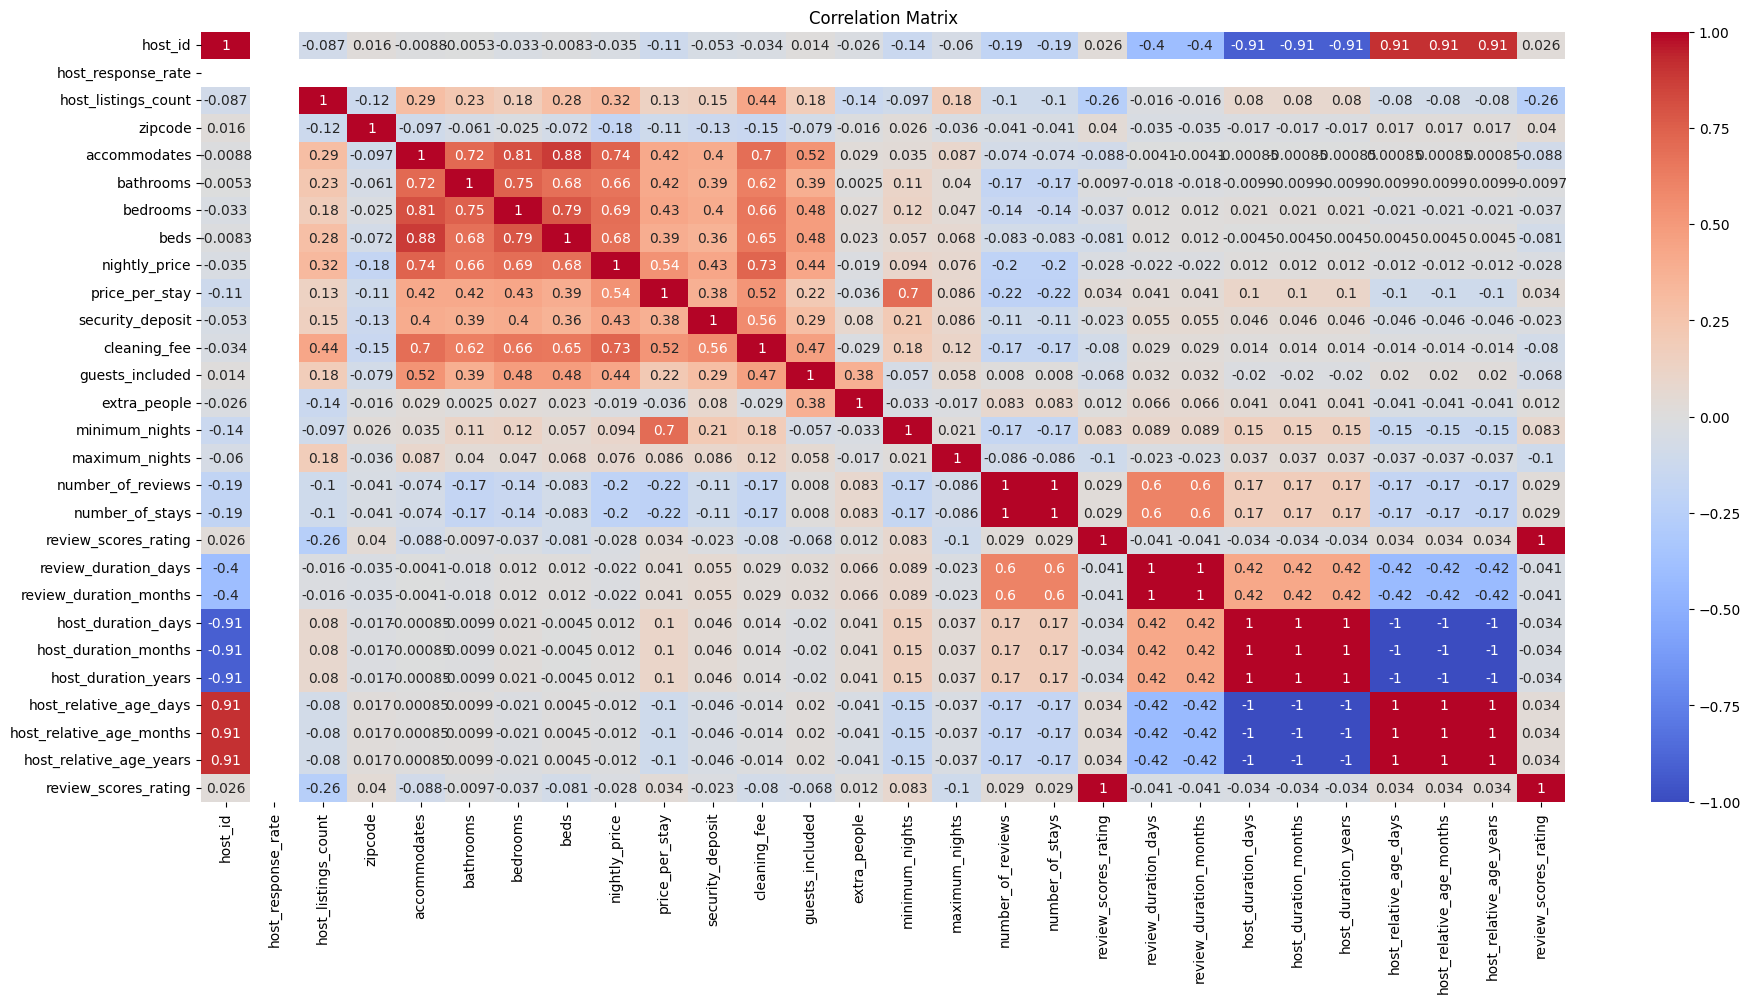

In [35]:
#Heat map for numerical values that can be easily read (law ntb3 al corr badl m nt7wel yb2a foll aw)
selected_cols = Numerical_cols + ['review_scores_rating']
corr_matrix = df[selected_cols].corr()

# Plot heatmap
plt.figure(figsize=(22, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



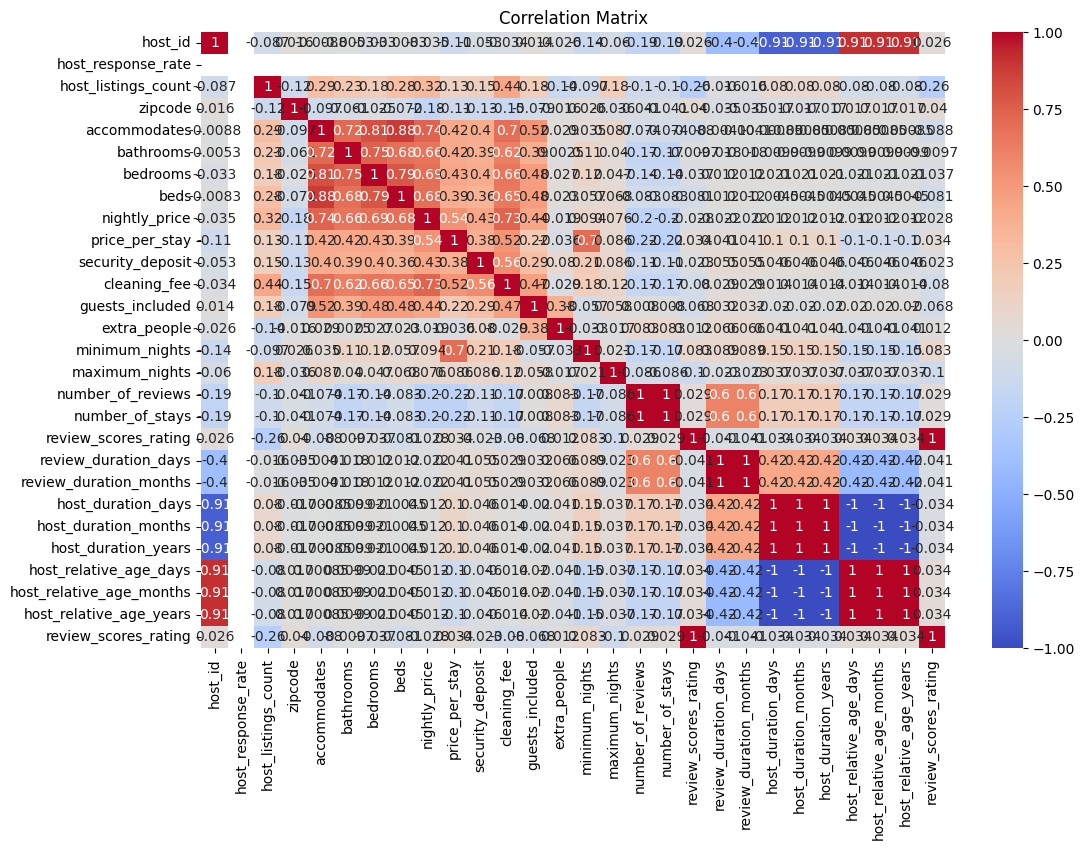

In [36]:
#Heat map for numerical values that can be easily read (law ntb3 al corr badl m nt7wel yb2a foll aw)
#momken nsta5dem al array Numerical_cols 3shan mn3rdsh kol al 7agat de 3 al fady
selected_cols = Numerical_cols + ['review_scores_rating']
corr_matrix = df[selected_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [37]:
#from the previous heat map we have selected coulmns with corr > 0.1
selected_coulmns = ['host_listings_count', 'accommodates', 'beds', 'cleaning_fee', 'minimum_nights', 'maximum_nights','review_scores_rating']

#make a new df with selected features
listing_features_df = df[selected_coulmns].copy()
print(listing_features_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8724 entries, 0 to 8723
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_listings_count   8724 non-null   float64
 1   accommodates          8724 non-null   float64
 2   beds                  8724 non-null   float64
 3   cleaning_fee          8724 non-null   float64
 4   minimum_nights        8724 non-null   float64
 5   maximum_nights        8724 non-null   float64
 6   review_scores_rating  8724 non-null   float64
dtypes: float64(7)
memory usage: 477.2 KB
None


---

Categorical Selection

---

In [38]:
object_cols = df.select_dtypes(include='object')
print(f"🧾 Number of object columns: {object_cols.shape[1]}")

🧾 Number of object columns: 20



✅ Top Source Columns by Number of Selected Features:
                                    score                  selected
                                     mean        max count      sum
source_column                                                      
host_about_cleaned               1.378700  19.334428  5000       30
house_rules_cleaned              1.377137  19.334428  5000       25
notes_cleaned                    1.266331  19.557917  5000       21
transit_cleaned                  1.026763  22.537875  5000        6
interaction_cleaned              1.014255  18.664927  4865        6
description_cleaned              1.252212  13.514332  5000        4
neighborhood_overview_cleaned    1.162128  14.153095  5000        3
cancellation_policy_cleaned     10.866475  19.370337     6        2
access_cleaned                   1.101418  29.108917  5000        2
host_neighbourhood_cleaned       1.444900  12.223082   203        1
host_location_cleaned            1.090956   6.433457   402    

<ipython-input-39-1410dbe5ef8e>:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='score', y='source_column', palette='viridis')


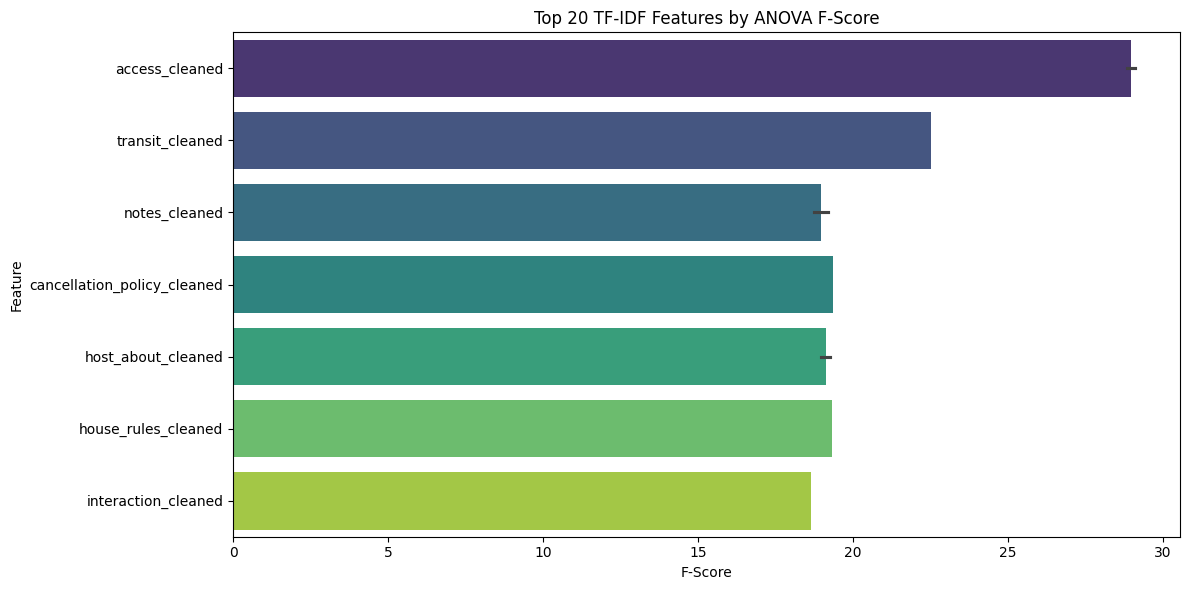

In [39]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

# --- Step 1: Load and prepare data ---
# Assuming df is already loaded with your data
target_col = 'review_scores_rating'
df = df.dropna(subset=[target_col])

# --- Step 2: Identify text columns ---
text_cols = df.select_dtypes(include='object').columns.tolist()
text_cols = [col for col in text_cols if df[col].notnull().sum() > 0]
df[text_cols] = df[text_cols].fillna("")

# --- Step 3: TF-IDF vectorization with source tracking ---
vectorizer = TfidfVectorizer(max_features=5000)
X_texts = []
feature_source = []

# Process each text column separately
for col in text_cols:
    try:
        X_col = vectorizer.fit_transform(df[col])
        if X_col.shape[1] == 0:
            continue
        X_texts.append(X_col)
        features = vectorizer.get_feature_names_out()
        feature_source.extend([col for _ in features])
    except ValueError:
        continue

# Combine all TF-IDF matrices
X_combined = hstack(X_texts)

# --- Step 4: Prepare target variable ---
y = df[target_col]
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# --- Step 5: Feature selection ---
selector = SelectKBest(score_func=f_classif, k=100)
X_selected = selector.fit_transform(X_combined, y)

# --- Step 6: Analyze results ---
selected_mask = selector.get_support()
scores = selector.scores_
pvalues = selector.pvalues_

feature_info = pd.DataFrame({
    'source_column': feature_source,
    'score': scores[:len(feature_source)],
    'p_value': pvalues[:len(feature_source)],
    'selected': selected_mask[:len(feature_source)]
}).sort_values(by='score', ascending=False)

source_stats = feature_info.groupby('source_column').agg({
    'score': ['mean', 'max', 'count'],
    'selected': 'sum'
}).sort_values(by=('selected', 'sum'), ascending=False)

top_avg_score = feature_info.groupby('source_column')['score'].mean().sort_values(ascending=False).head(20)
bottom_avg_score = feature_info.groupby('source_column')['score'].mean().sort_values(ascending=True).head(20)

# --- Step 7: Output results ---
print("\n✅ Top Source Columns by Number of Selected Features:")
print(source_stats.head(20).to_string())

print("\n📈 Top 20 Source Columns by Average F-score:")
top_avg_score = feature_info.groupby('source_column')['score'].mean().sort_values(ascending=False).head(20)
print(top_avg_score.to_string())

print("\n📉 Bottom 20 Source Columns by Average F-score:")
bottom_avg_score = feature_info.groupby('source_column')['score'].mean().sort_values(ascending=True).head(20)
print(bottom_avg_score.to_string())

# --- Step 10: Visualization of selected features ---
# Get the scores of only selected features
selected_scores = scores[selected_mask]
selected_feature_names = [feature_source[i] for i in range(len(feature_source)) if selected_mask[i]]

# Remove duplicates from selected feature names
unique_selected_feature_names = list(set(selected_feature_names))  # Remove duplicates using set

# Create a DataFrame for visualization
selected_features_df = pd.DataFrame({
    'feature': unique_selected_feature_names,
    'score': selected_scores[:len(unique_selected_feature_names)]  # Make sure score length matches
}).sort_values(by='score', ascending=False)

# Print the selected features and their scores (sorted by score)
print("\n✅ Selected Features and Their Scores (Without Duplicates):")
print(selected_features_df)

# --- Step 9: Visualization ---
top_features = feature_info.head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_features, x='score', y='source_column', palette='viridis')
plt.title('Top 20 TF-IDF Features by ANOVA F-Score')
plt.xlabel('F-Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()



---

Final Dataframe

---






In [40]:
best_text_columns = [ "host_about_cleaned","house_rules_cleaned","notes_cleaned","cancellation_policy_cleaned","description_cleaned","interaction_cleaned", "access_cleaned","room_type_cleaned","property_type_cleaned","host_response_time"]
Cat_features_df = df[best_text_columns].copy()
listing_features_df = listing_features_df.join(Cat_features_df)
listing_features_df = listing_features_df.join(binary_features_df)
listing_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8724 entries, 0 to 8723
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   host_listings_count            8724 non-null   float64
 1   accommodates                   8724 non-null   float64
 2   beds                           8724 non-null   float64
 3   cleaning_fee                   8724 non-null   float64
 4   minimum_nights                 8724 non-null   float64
 5   maximum_nights                 8724 non-null   float64
 6   review_scores_rating           8724 non-null   float64
 7   host_about_cleaned             8724 non-null   object 
 8   house_rules_cleaned            8724 non-null   object 
 9   notes_cleaned                  8724 non-null   object 
 10  cancellation_policy_cleaned    8724 non-null   object 
 11  description_cleaned            8724 non-null   object 
 12  interaction_cleaned            8724 non-null   o

# **Encoding**

In [41]:
df = df.replace({
    'require_guest_phone_verification': {'t': 1, 'f': 0},
    'require_guest_profile_picture': {'t': 1, 'f': 0},
    'instant_bookable': {'t': 1, 'f': 0},
    'is_location_exact': {'t': 1, 'f': 0},
    'host_identity_verified': {'t': 1, 'f': 0},
    'host_has_profile_pic': {'t': 1, 'f': 0},
    'is_business_travel_ready': {'t': 1, 'f': 0},
    'host_is_superhost': {'t': 1, 'f': 0},
    'requires_license': {'t': 1, 'f': 0}
})



<ipython-input-41-255601afc7ab>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({


In [42]:
label_cols = [
    'cancellation_policy_cleaned', 'room_type_cleaned', 'property_type_cleaned',
]

# Apply LabelEncoder to each column
le = LabelEncoder()

for col in label_cols:
    listing_features_df[col] = le.fit_transform(listing_features_df[col].astype(str))

In [43]:
le = LabelEncoder()
df['host_neighbourhood_cleaned'] = le.fit_transform(df['host_neighbourhood_cleaned'].astype(str))
num_neighborhoods = df['host_neighbourhood_cleaned'].nunique()

embedding_dim = 8
embedding_layer = tf.keras.layers.Embedding(input_dim=num_neighborhoods, output_dim=embedding_dim)

# Example: convert to tensor
neighbourhood_tensor = tf.convert_to_tensor(df['host_neighbourhood_cleaned'].values, dtype=tf.int32)
embedded_output = embedding_layer(neighbourhood_tensor)


In [44]:
mapping = {
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4
}

listing_features_df['host_response_time'] = listing_features_df['host_response_time'].map(mapping)

In [45]:
for col in ['host_response_time', 'cancellation_policy_cleaned', 'room_type_cleaned', 'property_type_cleaned']:
    if col in best_text_columns:
        best_text_columns.remove(col)
print(best_text_columns)

['host_about_cleaned', 'house_rules_cleaned', 'notes_cleaned', 'description_cleaned', 'interaction_cleaned', 'access_cleaned']


In [46]:
for col in best_text_columns:
    if col in TF_IDF.columns:
        listing_features_df[col] = TF_IDF[col]

# Make the target column at the end
cols = [col for col in listing_features_df.columns if col != 'review_scores_rating'] + ['review_scores_rating']
listing_features_df = listing_features_df[cols]

# **Final Dataframe after PreProcessing, Feature Engineering & Feature Selection**

In [47]:
listing_features_df.head(10)

,host_listings_count,accommodates,beds,cleaning_fee,minimum_nights,maximum_nights,host_about_cleaned,house_rules_cleaned,notes_cleaned,cancellation_policy_cleaned,...,has_tv,has_wifi,has_lock_on_bedroom_door,has_pool,has_gym,has_hot_tub,has_free_parking_on_premises,has_private_entrance,has_elevator,review_scores_rating
0,19.0,1.0,2.0,50.0,5.0,1125.0,0.000986,0.000998,0.000986,3,...,1,1,1,1,1,1,1,1,1,85.0
1,1.0,8.0,5.0,100.0,4.0,15.0,0.000990,0.000988,0.000990,1,...,1,1,0,0,0,0,1,0,0,97.0
2,12.0,3.0,1.0,90.0,1.0,1125.0,0.000968,0.000960,0.000993,3,...,1,1,0,0,0,1,1,1,0,98.0
3,7.0,2.0,1.0,75.0,2.0,1125.0,0.000990,0.000996,0.000991,1,...,1,1,0,0,0,0,0,0,1,98.0
4,21.0,6.0,4.0,165.0,2.0,1125.0,0.000959,0.000998,0.000988,3,...,1,1,1,0,0,0,0,1,0,100.0
5,3.0,6.0,3.0,105.0,3.0,1125.0,0.000943,0.000967,0.000985,1,...,1,1,0,0,0,0,1,1,0,97.0
6,15.0,12.0,6.0,280.0,2.0,1125.0,0.000977,0.000977,0.000962,3,...,1,1,0,1,0,1,1,0,0,100.0
7,8.0,4.0,3.0,200.0,4.0,1125.0,0.000958,0.000994,0.000991,3,...,1,1,1,1,0,1,0,1,0,100.0
8,1.0,3.0,2.0,30.0,1.0,1125.0,0.000991,0.000992,0.000987,1,...,0,1,1,0,0,0,0,1,0,94.0
9,1.0,3.0,1.0,0.0,4.0,5.0,0.000990,0.000990,0.000991,1,...,1,1,0,0,1,0,0,0,1,85.0


In [48]:
listing_features_df = listing_features_df.to_csv('Final_df.csv', index=False)